# Exploratory Data Analysis of Stimulus Triggered Averages
*Ian Malone*

#### Analysis plan

_Process the raw MEP recordings into STAs. This section was accomplished in a separate script, "mep-to-sta-batch.py"_
- Given raw evoked potential time series
- Find locations of delivered stimuli
- Capture 40 ms of evoked potential waveform after the stimuli occurred
- Account for differences in recording ampltiudes between animal cohorts
- Save these data to a MEP dataframe along with other information (Animal, Day, Stimulus Amplitude, Diaphragm Side, Sample)
- Average MEPs to create STA dataframe. Both the MEP and STA dataframe contain time series
- Export these dataframes as .csv files for further analysis

_Inspect the raw STA signals_
- Align days properly (different animals had measurements on different days)
- Remove stimulus artifact
- Scale the STAs to be in [0,1]
- Visually inspect raw STAs by plotting
- Decide if some data must be removed

_Analyze metrics output by Spike2 (peak-to-peak amplitude and area under the curve for the left and right side across all days and time bins_
- Import the Spike2 dataframe
- Clean as necessary
- Rescale certain measurements to account for different recording gain
- Create a min-max rescaled dataframe
- Check to make sure the distribution of data is preserved after rescaling
- Explore all variables not controlled for and pool if possible (e.g., # hours stim, time between stim and measurement, time of day, day postop)
- Create plots
    - Time to peak
        - For this you need to work with raw signal data
        - Calculate the time from 1 ms after stim pulse to the max(signal) and max(abs(signal))
        - Rescaled and non-rescaled
        - Left and right sides
        - All time bins
        - All four groups
        - All four days
        - sns.violinplot
    - Peak-to-peak (P2P)
        - Rescaled and non-rescaled
        - Left and right sides
        - All time bins
        - All four groups
        - All four days
        - sns.lmplot
    - Area under the curve (AUC)
        - Rescaled and non-rescaled
        - Left and right sides
        - All time bins
        - All four groups
        - All four days
        - sns.lmplot
    - Aggregate time bins
        - P2P and AUC
        - Rescaled and non-rescaled
        - Average values between 349 and 401 uA
        - Left and right sides
        - All time bins
        - All four groups
        - All four days
        - sns.violinplot
    - Threshold changes
        - Marissa is sending these data
        - You may need to adjust the values to account for recording differences (like you did with stim. amplitude)
        - Percent change in motor threshold
        - Left and right sides
        - All time bins
        - All four groups
        - All four days (d1 to d2, d1 to d3, d1 to d4)
        - sns.violinplot

## Stimulus Triggered Average Signals

#### Load STA dataframe to inspect raw signals

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filename = 'df_STA_NEIL_2021_03_01'

project = 'NEIL' if 'NEIL' in filename else 'SPARC'
path = 'D:\\Dataframe_CSVs\\%s.csv' % filename # desktop
# path = 'C:\\Users\\iangm\\Google Drive\\IanGMalone\\Desktop_Stuff\\For-Me\\Dataframe_CSVs\\%s.csv' % filename # laptop

df_sta = pd.read_csv(path)

#### Define color palette to use in later plots

In [2]:
# C2HS+EES, C2HS+Sham, NoInj+EES, NoInj+Sham
colors = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']
sns.set_palette(sns.color_palette(colors))
# this palette is accessible to different types of colorblindness
# https://davidmathlogic.com/colorblind/#%23D81B60-%231E88E5-%23FFC107-%23004D40

## marissa colors
# colors = ['#B8BA2B', '#E44A35', '#0EB09C', '#943852']
# sns.set_palette(sns.color_palette(colors))

#### Add 'Time' column based on 'Sample' and a sampling frequency of 5000 Hz

In [3]:
sampling_frequency = 5000 # hertz
df_sta['Time'] = df_sta['Sample']/sampling_frequency # create time column based on samples and sampling frequency
df_sta['Time'] = df_sta['Time']*1000
df_sta = df_sta.drop(columns=['Sample'])

#### Drop 'Day_Postop' feature for now

In [4]:
df_sta = df_sta.drop(['Day_Postop'], axis=1)

#### Define function to add group information to dataframe

In [5]:
### groups for NEIL project
injstim = ['N09','N10','N11','N13','N27','N28','N29','N30','N34']
noinjstim = ['N01','N04','N05','N31','N32','N33','N35'] 
injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

### groups for SPARC project
groupa = ['S01', 'S02']
groupb = ['S03', 'S04']
groupc = ['S05', 'S06']

# add animal group information to the dataframe
# make a function so you can apply to multiple dataframes
def add_group(df):
    '''This function adds Group column to dataframe based on Animal column'''
    if project == 'NEIL':
        conditions = [
            (df['Animal'].isin(injstim)),
            (df['Animal'].isin(noinjstim)),
            (df['Animal'].isin(injnostim)),
            (df['Animal'].isin(noinjnostim)) ]
        choices = ['Yes Injury, Yes EES', 'No Injury, Yes EES', 'Yes Injury, No EES', 'No Injury, No EES']
        df['Group'] = np.select(conditions, choices)
    elif project == 'SPARC':
        conditions = [
            (df['Animal'].isin(groupa)),
            (df['Animal'].isin(groupb)),
            (df['Animal'].isin(groupc)) ]
        choices = ['Group A', 'Group B', 'Group C']
        df['Group'] = np.select(conditions, choices)       

#### Check raw STAs by plotting

In [6]:
# g = sns.FacetGrid(df_sta[(df_sta['Stim_Amplitude'] % 10 == 0) & (df_sta['Side'] == 'Left')], col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# g.figure.savefig("D:\\raw_stas.png")

#### Adjust days so they are properly aligned

In [7]:
# we will call day 1 the day when baseline (no stimulation yet) measurements were taken
# early animals were recorded in this way
# recent animals had this called day 0
recent_animals = ['N27','N28','N29','N30','N31','N32','N33','N34']
df_sta.loc[df_sta['Animal'].isin(recent_animals), 'Day_Stim']+=1
df_sta = df_sta[df_sta['Day_Stim'] < 5]

#### Delete bad data

In [8]:
# delete N29 from dataframe (recordings were badly messed up)
df_sta = df_sta[df_sta['Animal'] != 'N29']

#### Remove stimulus artifact

In [9]:
# remove the stimulus artifact
df_sta_noart = df_sta.copy()
df_sta_noart = df_sta_noart[df_sta_noart['Time'] > 1]

#### Plot cleaned STAs

In [10]:
# g = sns.FacetGrid(df_sta_noart[(df_sta_noart['Stim_Amplitude'] % 10 == 0)], col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# g.figure.savefig("D:\\cleaned_stas.png")

#### Scale the STAs to occupy [0,1]

In [11]:
df_scaled = df_sta_noart.copy()

# for easier scaling, reshape the dataframe from long to wide format
df_scaled = df_scaled.pivot_table(index=['Day_Stim', 'Stim_Amplitude', 'Time', 'Side'], 
                    columns='Animal', 
                    values='STA_Amplitude')

In [12]:
# import the scaler and perfrom 0-1 rescaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled[df_scaled.columns] = scaler.fit_transform(df_scaled[df_scaled.columns])

In [13]:
# convert dataframe back to long format
animal_cols = df_scaled.columns
df_scaled.reset_index(inplace=True)
df_scaled.columns.name = None
df_sta_scaled = pd.melt(df_scaled, id_vars=['Day_Stim', 'Stim_Amplitude', 'Time', 'Side'], value_vars=animal_cols, var_name='Animal', value_name='STA_Amplitude')

#### Plot the normalized STAs

In [14]:
add_group(df_sta_scaled)

In [15]:
df_sta_scaled.head()

Day_Stim  Stim_Amplitude  Time   Side Animal  STA_Amplitude  \
0         1            10.0   1.2   Left    N01       0.502475   
1         1            10.0   1.2  Right    N01       0.512611   
2         1            10.0   1.4   Left    N01       0.508201   
3         1            10.0   1.4  Right    N01       0.512556   
4         1            10.0   1.6   Left    N01       0.519806   

                Group  
0  No Injury, Yes EES  
1  No Injury, Yes EES  
2  No Injury, Yes EES  
3  No Injury, Yes EES  
4  No Injury, Yes EES

In [16]:
# sns.set(font_scale=1)
# g = sns.FacetGrid(df_sta_scaled[(df_sta_scaled['Stim_Amplitude'] % 50 == 0) 
#                                 & (df_sta_scaled['Time']< 20) 
#                                 & (df_sta_scaled['Stim_Amplitude']< 601)
#                                 & (df_sta_scaled['Side']=='Left')
#                                 & (df_sta_scaled['Day_Stim'].isin([1,4]))
#                                 & (df_sta_scaled['Group']=='Yes Injury, Yes EES')],
#                   col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# g.savefig("D:\\Neilsen\\Neilsen_Figures\\responders.pdf")

# # g = sns.scatterplot(data=df_neilsen_scaled[(df_neilsen_scaled['Side']=='Left') 
# #                                        & (df_neilsen_scaled['Time_Bin']=='1_to_21ms') 
# #                                        & (df_neilsen_scaled['Metric']=='p2p')
# #                                        & (df_neilsen_scaled['Day']==4)
# #                                        & (df_neilsen_scaled['Group']=='No Injury, Yes EES')],
# #                 x='Stim_Amp', y='Scalar_Original_Value',hue='Animal')
                

In [17]:
# sns.set(font_scale=1)
# g = sns.FacetGrid(df_sta_scaled[(df_sta_scaled['Stim_Amplitude'] % 50 == 0) & (df_sta_scaled['Time']< 20) & (df_sta_scaled['Side']=='Left')], col='Day_Stim', row='Animal', hue='Stim_Amplitude')
# g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude')
# g.set_axis_labels('Time (ms)', 'Ampltiude (V)')
# g.add_legend()
# g.savefig("D:\\Neilsen\\Neilsen_Figures\\scaled-sta-signals.pdf")

#### Time to peak

- Time to peak
    - For this you need to work with raw signal data
    - Calculate the time from 1 ms after stim pulse to the max(signal) and max(abs(signal))
    - Rescaled and non-rescaled
    - Left and right sides
    - All time bins
    - All four groups
    - All four days
    - sns.violinplot

In [18]:
df_sta_scaled[df_sta_scaled['Stim_Amplitude']==600].Animal.unique()

array(['N01', 'N04', 'N05', 'N09', 'N10', 'N11', 'N13', 'N14', 'N15',
       'N16', 'N17', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25',
       'N26', 'N27', 'N28', 'N30', 'N31', 'N32', 'N33', 'N34'],
      dtype=object)

In [19]:
df_sta_scaled.groupby(['Animal']).Stim_Amplitude.unique()

Animal
N01    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N04    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N05    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N09    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N10    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N11    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N13    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N14    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N15    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N16    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N17    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N19    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N20    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N21    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N22    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N23    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N24    [10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45....
N25    [10.0, 15.0, 20.0

In [129]:
# only consider 20ms of data
df_time_to_peak = df_sta_scaled.copy()
df_time_to_peak = df_time_to_peak[df_time_to_peak['Time']<=20]

# remove right side recordings for N01, N04, and N05 (just noise)
drop_right_animals = ['N01', 'N04', 'N05']
df_time_to_peak.drop(df_time_to_peak[(df_time_to_peak['Side']=='Right') & (df_time_to_peak['Animal'].isin(drop_right_animals))].index, inplace = True)

df_time_to_peak = df_time_to_peak.loc[df_time_to_peak.groupby(['Day_Stim', 'Stim_Amplitude', 'Side', 'Animal'])['STA_Amplitude'].idxmax().dropna()].reset_index().drop(columns=['index'])
df_time_to_peak = df_time_to_peak.rename(columns={'Time':'Peak_Time'})
df_time_to_peak = df_time_to_peak.rename(columns={'Day_Stim': 'Day', 'Stim_Amplitude' : 'Stim_Amp'})
df_time_to_peak = df_time_to_peak.drop(columns=['STA_Amplitude'])
# df_time_to_peak = df_time_to_peak[(df_time_to_peak['Stim_Amp'].between(299,401))]
df_time_to_peak.to_csv('D:\\Neilsen\\Dataframes\\df_time_to_peak.csv')
df_time_to_peak.head()

Day  Stim_Amp  Peak_Time  Side Animal                Group
0    1      10.0        2.0  Left    N01   No Injury, Yes EES
1    1      10.0        1.8  Left    N04   No Injury, Yes EES
2    1      10.0        6.2  Left    N05   No Injury, Yes EES
3    1      10.0        3.8  Left    N09  Yes Injury, Yes EES
4    1      10.0       10.4  Left    N10  Yes Injury, Yes EES

In [130]:
# plotter = df_time_to_peak[(df_time_to_peak['Stim_Amp'].between(299,401)) & (df_time_to_peak['Day'].isin([1,4]))]

plotter = df_time_to_peak[(df_time_to_peak['Day'].isin([1,4]))]


plotter['Injury'] = np.where(plotter['Group'].str.contains("Yes Injury"), "Yes Injury", "No Injury")
plotter['Therapy'] = np.where(plotter['Group'].str.contains("Yes EES"), "Yes Therapy", "No Therapy")
plotter.head()

<ipython-input-130-aeaba0ada304>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotter['Injury'] = np.where(plotter['Group'].str.contains("Yes Injury"), "Yes Injury", "No Injury")
<ipython-input-130-aeaba0ada304>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotter['Therapy'] = np.where(plotter['Group'].str.contains("Yes EES"), "Yes Therapy", "No Therapy")


Day  Stim_Amp  Peak_Time  Side Animal                Group      Injury  \
0    1      10.0        2.0  Left    N01   No Injury, Yes EES   No Injury   
1    1      10.0        1.8  Left    N04   No Injury, Yes EES   No Injury   
2    1      10.0        6.2  Left    N05   No Injury, Yes EES   No Injury   
3    1      10.0        3.8  Left    N09  Yes Injury, Yes EES  Yes Injury   
4    1      10.0       10.4  Left    N10  Yes Injury, Yes EES  Yes Injury   

       Therapy  
0  Yes Therapy  
1  Yes Therapy  
2  Yes Therapy  
3  Yes Therapy  
4  Yes Therapy

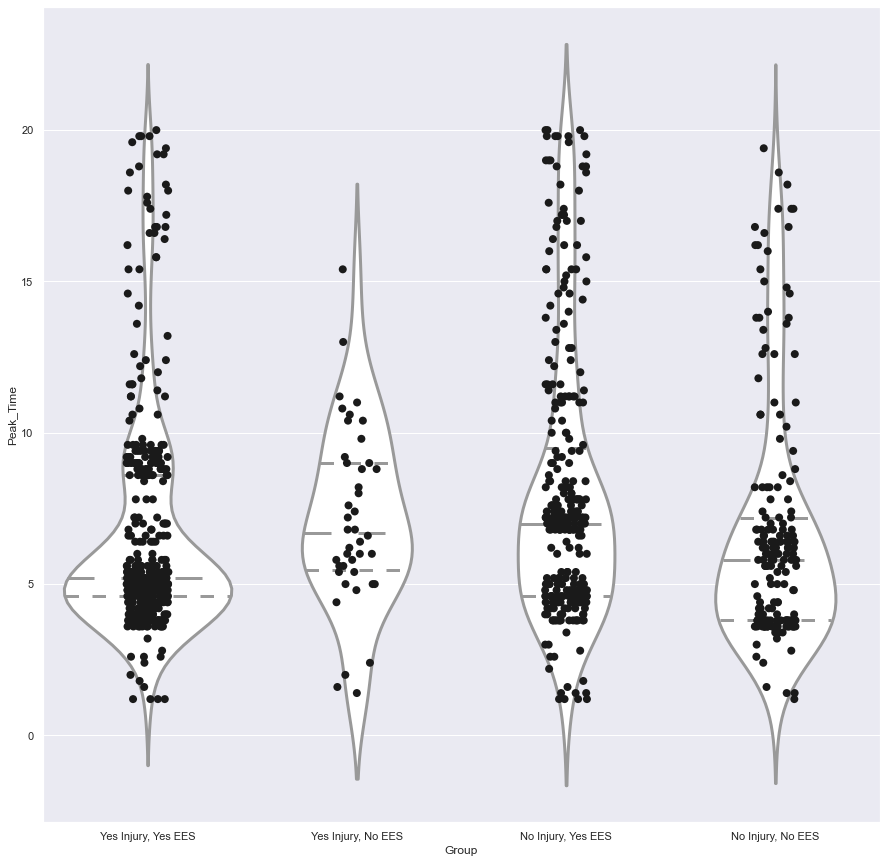

In [131]:


sns.stripplot(data=plotter[(plotter['Side']=='Left') & (plotter['Day']==4)], x="Group", y="Peak_Time", 
              color='k', size=8, order=['Yes Injury, Yes EES', 'Yes Injury, No EES', 
                                            'No Injury, Yes EES', 'No Injury, No EES'])



ax = sns.violinplot(data=plotter[(plotter['Side']=='Left') & (plotter['Day']==4)], x="Group", 
                    y="Peak_Time", inner="quartile", color='white', linewidth=3, 
                    order=['Yes Injury, Yes EES', 'Yes Injury, No EES', 
                                            'No Injury, Yes EES', 'No Injury, No EES'])


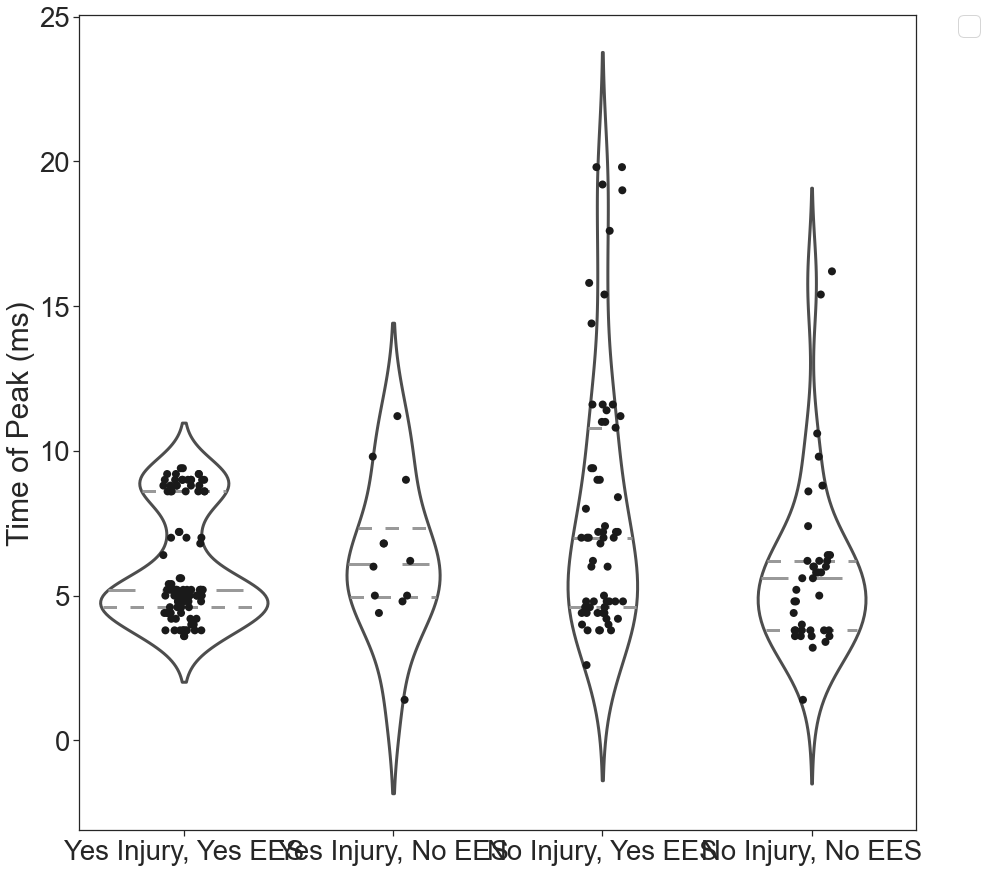

In [23]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=2.5)
sns.set_style("ticks")

#sns.set_palette(sns.color_palette(colors))

def patch_violinplot():
     from matplotlib.collections import PolyCollection
     ax = plt.gca()
     for art in ax.get_children():
          if isinstance(art, PolyCollection):
              art.set_edgecolor((0.3, 0.3, 0.3))



sns.stripplot(data=plotter[(plotter['Side']=='Left') & (plotter['Day']==4)], x="Group", y="Peak_Time", 
              color='k', size=8, order=['Yes Injury, Yes EES', 'Yes Injury, No EES', 
                                            'No Injury, Yes EES', 'No Injury, No EES'])



ax = sns.violinplot(data=plotter[(plotter['Side']=='Left') & (plotter['Day']==4)], x="Group", 
                    y="Peak_Time", inner="quartile", color='white', linewidth=3, 
                    order=['Yes Injury, Yes EES', 'Yes Injury, No EES', 
                                            'No Injury, Yes EES', 'No Injury, No EES'])


patch_violinplot()


# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set(xlabel=None, ylabel='Time of Peak (ms)')

fig=ax.get_figure()
# fig.savefig("D:\\time-of-peak.png", dpi=300)


## Spike2 Data Analysis

#### Load Spike2 dataframe

In [24]:
neilsen_path = 'D:\\Neilsen\\All_Data_Neilsen.csv' # desktop
# neilsen_path = 'C:\\Users\\iangm\\Google Drive\\IanGMalone\\Desktop_Stuff\\For-Me\\Neilsen\\All_Data_Neilsen.csv' # laptop
df = pd.read_csv(neilsen_path)
df.head()

Animal  Day  Stim Amp  LPkPk1to5  LPkPk5to9  LPkPk9to13  LMod1to5  LMod5to9  \
0    N01    1  0.100484   0.040588   0.029765    0.028320  0.000044  0.000017   
1    N01    1  0.200399   0.018412   0.022990    0.030416  0.000019  0.000029   
2    N01    1  0.300578   0.035543   0.034241    0.037984  0.000025  0.000033   
3    N01    1  0.400330   0.058105   0.041423    0.026917  0.000054  0.000041   
4    N01    1  0.500326   0.073853   0.068848    0.038432  0.000062  0.000060   

   LMod9to13  RPkPk1to5  ...  LPkPk1to21  LMod13to17  LMod17to21  LMod1to21  \
0   0.000023   0.000793  ...    0.040588    0.000019    0.000020   0.000124   
1   0.000036   0.000875  ...    0.044393    0.000018    0.000043   0.000145   
2   0.000038   0.001241  ...    0.041707    0.000018    0.000036   0.000150   
3   0.000028   0.000916  ...    0.058105    0.000043    0.000030   0.000195   
4   0.000033   0.000834  ...    0.087708    0.000054    0.000035   0.000243   

   RPkPk13to17  RPkPk17to21  RPkPk1to21  RMod13to17  RMod17to21  RMod1to21  
0     0.000488     0.000692    0.001465    0.000004    0.000002   0.000016  
1     0.000753     0.000529    0.001322    0.000005    0.000003   0.000017  
2     0.001343     0.000753    0.001485    0.000003    0.000004   0.000018  
3     0.001221     0.001099    0.001506    0.000003    0.000004   0.000018  
4     0.000671     0.000814    0.001383    0.000002    0.000004   0.000018  

[5 rows x 27 columns]

#### Adjust stimulation factor to equalize across groups

In [25]:
early_animals = ['N01','N04','N05','N09','N10','N11','N13']

df_neilsen = df.copy()
df_neilsen['Stim Amp'] = np.round(np.where(df['Animal'].isin(early_animals), df['Stim Amp']/10, df['Stim Amp']),2)

# df_neilsen.groupby(df_neilsen['Animal'])['Stim_Amp'].unique()

#### Reorganize dataframe into long format

In [26]:
neilsen_value_columns = df_neilsen.columns.tolist()[3:]

df_neilsen = pd.melt(df_neilsen, id_vars=['Animal', 'Day', 'Stim Amp'], value_vars=neilsen_value_columns, value_name='Value')

df_neilsen['Side'] = np.where(df_neilsen['variable'].str[0] == 'L', 'Left', 'Right')
df_neilsen['Metric'] = np.where(df_neilsen['variable'].str[1] == 'P', 'p2p', 'auc')

df_neilsen.head()

Animal  Day  Stim Amp   variable     Value  Side Metric
0    N01    1      0.01  LPkPk1to5  0.040588  Left    p2p
1    N01    1      0.02  LPkPk1to5  0.018412  Left    p2p
2    N01    1      0.03  LPkPk1to5  0.035543  Left    p2p
3    N01    1      0.04  LPkPk1to5  0.058105  Left    p2p
4    N01    1      0.05  LPkPk1to5  0.073853  Left    p2p

In [27]:
def time_bin_conditions(df):
    if '1to5' in df['variable']:
        return '1_to_5ms'
    elif '5to9' in df['variable']:
        return '5_to_9ms'
    elif '9to13' in df['variable']:
        return '9_to_13ms'
    elif '13to17' in df['variable']:
        return '13_to_17ms'
    elif '17to21' in df['variable']:
        return '17_to_21ms'
    elif '1to21' in df['variable']:
        return '1_to_21ms'
    else:
        return 'n/a' 

df_neilsen['Time_Bin'] = df_neilsen.apply(time_bin_conditions, axis=1)
# df_neilsen.head()

In [28]:
# clean up dataframe a bit

df_neilsen = df_neilsen.rename(columns={'Stim Amp' : 'Stim_Amp'})
add_group(df_neilsen)
df_neilsen = df_neilsen.drop(columns=['variable'])
df_neilsen['Stim_Amp'] = df_neilsen['Stim_Amp']*1000
df_neilsen = df_neilsen[['Animal', 'Day', 'Stim_Amp', 'Group', 'Side', 'Time_Bin', 'Metric', 'Value']]
df_neilsen = df_neilsen[df_neilsen['Day'] < 5]
df_neilsen = df_neilsen[df_neilsen['Stim_Amp'] <= 600]
df_neilsen.head()

Animal  Day  Stim_Amp               Group  Side  Time_Bin Metric     Value
0    N01    1      10.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.040588
1    N01    1      20.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.018412
2    N01    1      30.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.035543
3    N01    1      40.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.058105
4    N01    1      50.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.073853

#### Divide necessary groups by a scalar to account for differences in recording gain

In [29]:
df_neilsen_scaled = df_neilsen.copy()
div_10_animals = ['N14', 'N15', 'N16', 'N17', 'N19', 'N20', 'N21', 'N22', 'N23']
df_neilsen_scaled['Scalar_Original_Value'] = df_neilsen_scaled['Value']
df_neilsen_scaled.loc[df_neilsen_scaled['Animal'].isin(div_10_animals), 'Scalar_Original_Value'] /= 10

#### Rescale all data into [0,1]

- For each animal, and each metric:
    - Min-max scale by looking at all values across the 4 days (max of 4 days for an animal is 1, min is 0, all else scaled realtively)


In [30]:
from sklearn.preprocessing import minmax_scale

df_neilsen_scaled['Minmax_Original_Value'] = df_neilsen_scaled.groupby(['Animal', 'Metric'])['Value'].transform(lambda x: minmax_scale(x.astype(float)))
# df_neilsen_scaled['Minmax_Scalar_Value'] = df_neilsen_scaled.groupby(['Animal', 'Metric'])['Scalar_Original_Value'].transform(lambda x: minmax_scale(x.astype(float)))

<Figure size 1728x864 with 0 Axes>

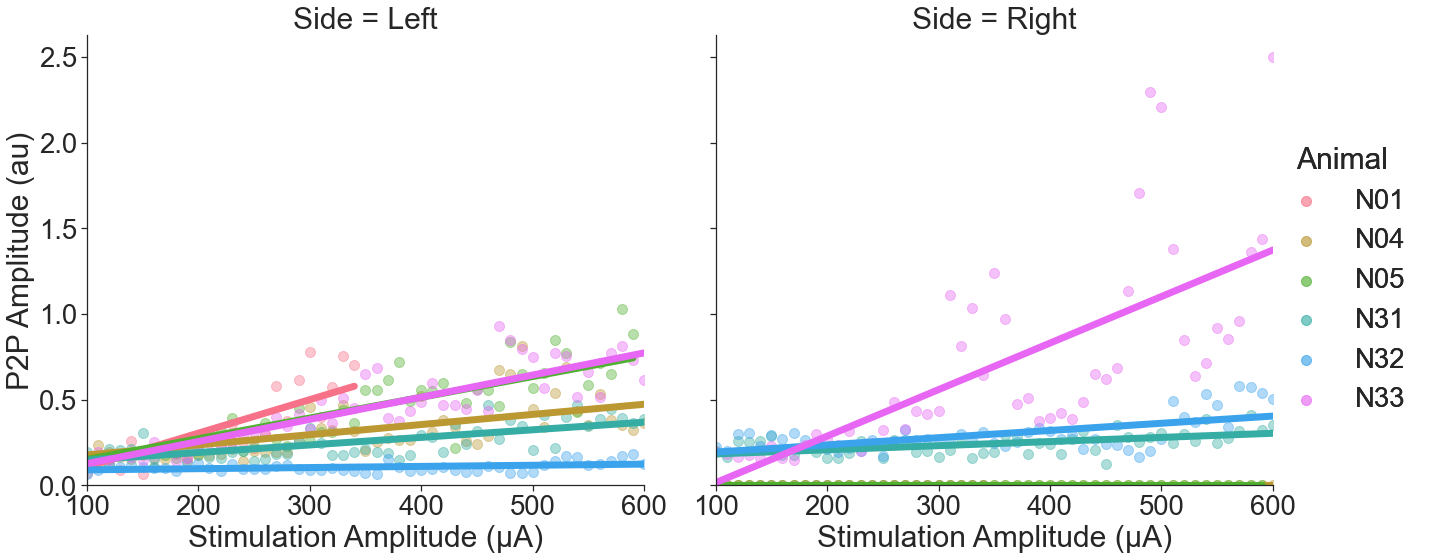

In [31]:
### make some plots to check Intact + CLES group large increase in contralateral day 3

plt.figure(figsize=(24,12))
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()
#palette="tab10",

sns.set_palette(sns.color_palette(colors))

g = sns.lmplot(x='Stim_Amp', y='Scalar_Original_Value', hue='Animal', col='Side',
                data=df_neilsen_scaled[(df_neilsen_scaled['Time_Bin']=='1_to_21ms') 
                                                        & (df_neilsen_scaled['Metric']=='p2p')
                                                        & (df_neilsen_scaled['Group']=='No Injury, Yes EES')
                                                        & (df_neilsen_scaled['Day'].isin([4]))],
       order=1, ci=0,  height=8,
       scatter_kws={"s": 100, "alpha": 0.4}, line_kws={"lw":7})

g.set(xlim=(100, None), ylim=(0, None))

g.set_axis_labels("Stimulation Amplitude (μA)", "P2P Amplitude (au)")
g.add_legend()
g.fig.subplots_adjust(top=.90) # adjust the Figure in rp



### Export Dataframes for Stats in R

In [34]:
df_neilsen_scaled.head()

Animal  Day  Stim_Amp               Group  Side  Time_Bin Metric     Value  \
0    N01    1      10.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.040588   
1    N01    1      20.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.018412   
2    N01    1      30.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.035543   
3    N01    1      40.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.058105   
4    N01    1      50.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.073853   

   Scalar_Original_Value  Minmax_Original_Value  
0               0.040588               0.047042  
1               0.018412               0.021145  
2               0.035543               0.041150  
3               0.058105               0.067498  
4               0.073853               0.085888

In [35]:
df_neilsen_scaled = df_neilsen_scaled.drop(df_neilsen_scaled[(df_neilsen_scaled['Animal']=='N33') 
                                                             & (df_neilsen_scaled['Day']==3) 
                                                             & (df_neilsen_scaled['Side']=='Right')].index)
df_neilsen_scaled.to_csv('D:\\Neilsen\\Dataframes\\df_neilsen.csv')
df_neilsen_scaled.head()

Animal  Day  Stim_Amp               Group  Side  Time_Bin Metric     Value  \
0    N01    1      10.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.040588   
1    N01    1      20.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.018412   
2    N01    1      30.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.035543   
3    N01    1      40.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.058105   
4    N01    1      50.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.073853   

   Scalar_Original_Value  Minmax_Original_Value  
0               0.040588               0.047042  
1               0.018412               0.021145  
2               0.035543               0.041150  
3               0.058105               0.067498  
4               0.073853               0.085888

In [36]:
df_neilsen_scaled[(df_neilsen_scaled['Group']=='No Injury, Yes EES') 
                                                             & (df_neilsen_scaled['Day']==3) 
                                                             & (df_neilsen_scaled['Side']=='Right')].Animal.unique()

array(['N01', 'N31', 'N32'], dtype=object)

### Make Percent Change Dataframe

In [37]:
# df_pchange = df_neilsen_scaled.copy()
# df_pchange = df_pchange[df_pchange['Day'].isin([1,4])]
# df_pchange = df_pchange.pivot_table(index=['Animal', 'Stim_Amp', 'Group', 'Side', 'Time_Bin', 'Metric'], columns='Day', values=['Value','Scalar_Original_Value','Minmax_Original_Value']).reset_index()
# df_pchange = df_pchange.rename_axis(None, axis=1)
# df_pchange.head()

### Plot

When plotting you may want to:
- Remove day 5 data because most animals only have data through day 4
- Remove stimulation amplitudes above 600 uA for the same reason as above

#### Peak-to-peak amplitude

- Peak-to-peak (P2P)
    - Scalar rescaled
    - Left and right sides
    - All time bins
    - All four groups
    - All four days
    - sns.lmplot

In [38]:
# def lmplot(df, yy, side, time, metric, xx='Stim_Amp', ccol='Group', hhue='Day'):
#     plt.figure(figsize=(24,12))
#     sns.set(font_scale=2.5)
#     sns.set_style("ticks")
#     sns.despine()

#     ax = sns.lmplot(x=xx, y=yy, col=ccol, hue=hhue, data=df[(df['Side']==side) 
#                                                             & (df['Time_Bin']==time) 
#                                                             & (df['Metric']==metric)],
#            col_wrap=2, order=1, ci=0, palette="tab10", height=8,
#            scatter_kws={"s": 50, "alpha": 0.3})
#     ax.set(ylim=(0, None))
    
#     return ax

<Figure size 1728x864 with 0 Axes>

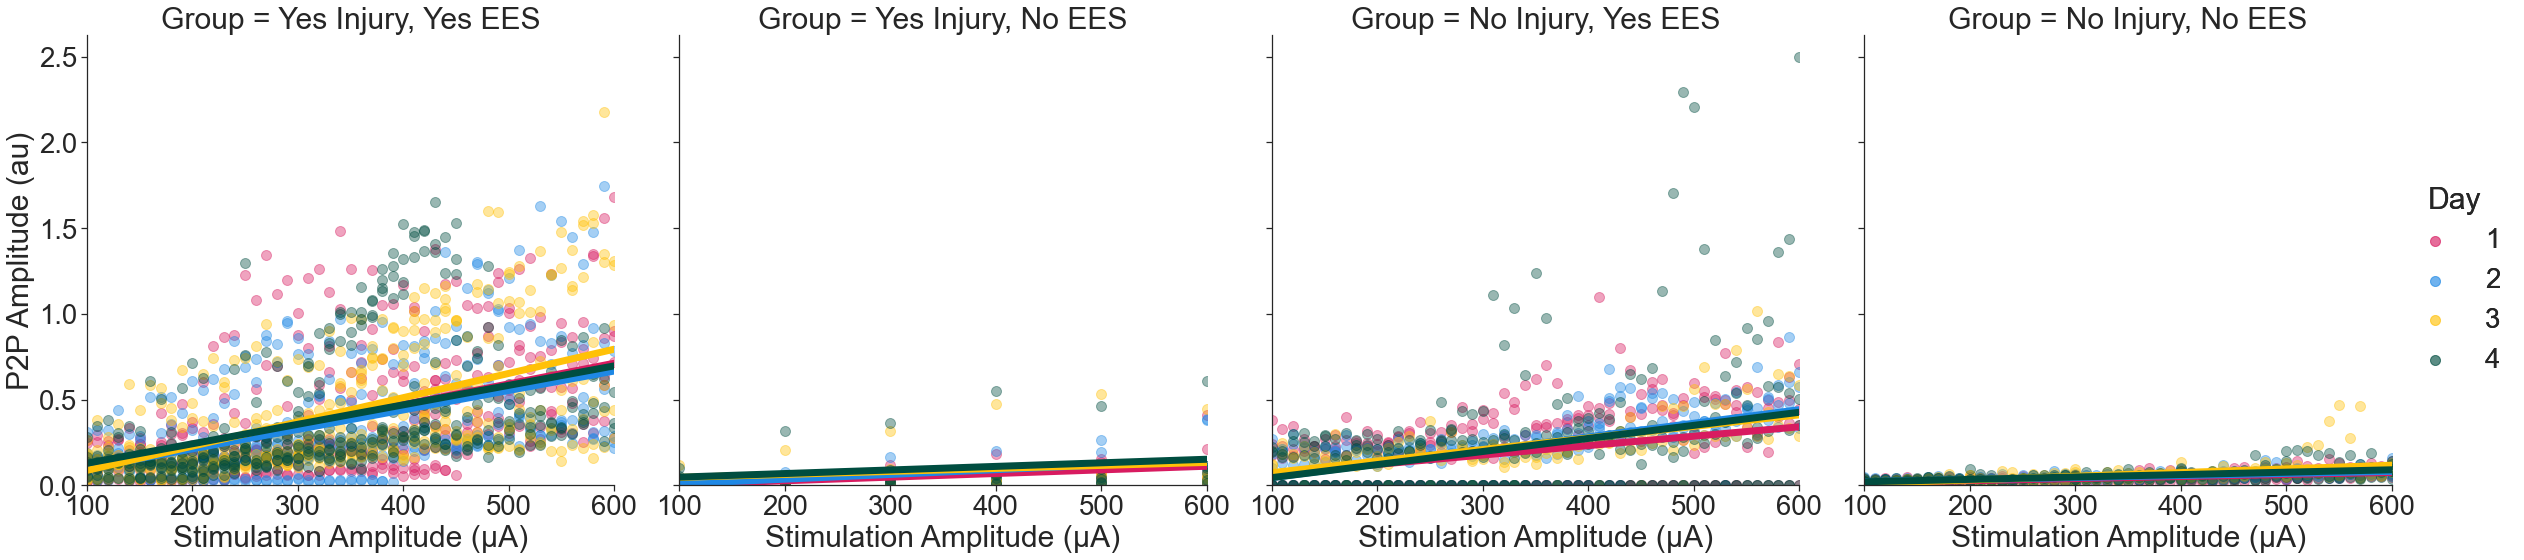

In [39]:
plt.figure(figsize=(24,12))
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()
#palette="tab10",

sns.set_palette(sns.color_palette(colors))

df_groups_plot = df_neilsen_scaled.copy()
df_groups_plot = df_groups_plot[(df_groups_plot['Time_Bin']=='1_to_21ms') 
                                    & (df_groups_plot['Metric']=='p2p')]

g = sns.lmplot(x='Stim_Amp', y='Scalar_Original_Value', col='Group', hue='Day', 
                data=df_groups_plot[df_groups_plot['Side']=='Right'],
       order=1, ci=0,  height=8, col_order=['Yes Injury, Yes EES', 'Yes Injury, No EES', 
                                            'No Injury, Yes EES', 'No Injury, No EES'],
       scatter_kws={"s": 100, "alpha": 0.4}, line_kws={"lw":7})

g.set(xlim=(100, None), ylim=(0, None))
#g.spines['left'].set_linewidth(5)

g.set_axis_labels("Stimulation Amplitude (μA)", "P2P Amplitude (au)")
g.add_legend()
g.fig.subplots_adjust(top=.90) # adjust the Figure in rp
# g.fig.suptitle('Peak-to-Peak Amplitude, Left Side')
g.savefig("D:\\left-p2p-scalar.png", dpi=300)

df_groups_plot['Side'] = df_groups_plot['Side'].replace({'Left':'Ipsilesional', 'Right':'Contralesional'})
df_groups_plot['Group'] = df_groups_plot['Group'].replace({'No Injury, Yes EES':'Intact + CLES', 
                                                           'Yes Injury, Yes EES':'C2HS + CLES',
                                                           'Yes Injury, No EES':'C2HS',
                                                           'No Injury, No EES':'Intact'})

df_groups_plot.to_csv('D:\\Neilsen\\Dataframes\\df_groups_plot.csv')


In [40]:
df_groups_plot.Group.unique()

array(['Intact + CLES', 'C2HS + CLES', 'C2HS', 'Intact'], dtype=object)

Text(0.5, 0.98, 'Peak-to-Peak Amplitude, Right Side')

<Figure size 1728x864 with 0 Axes>

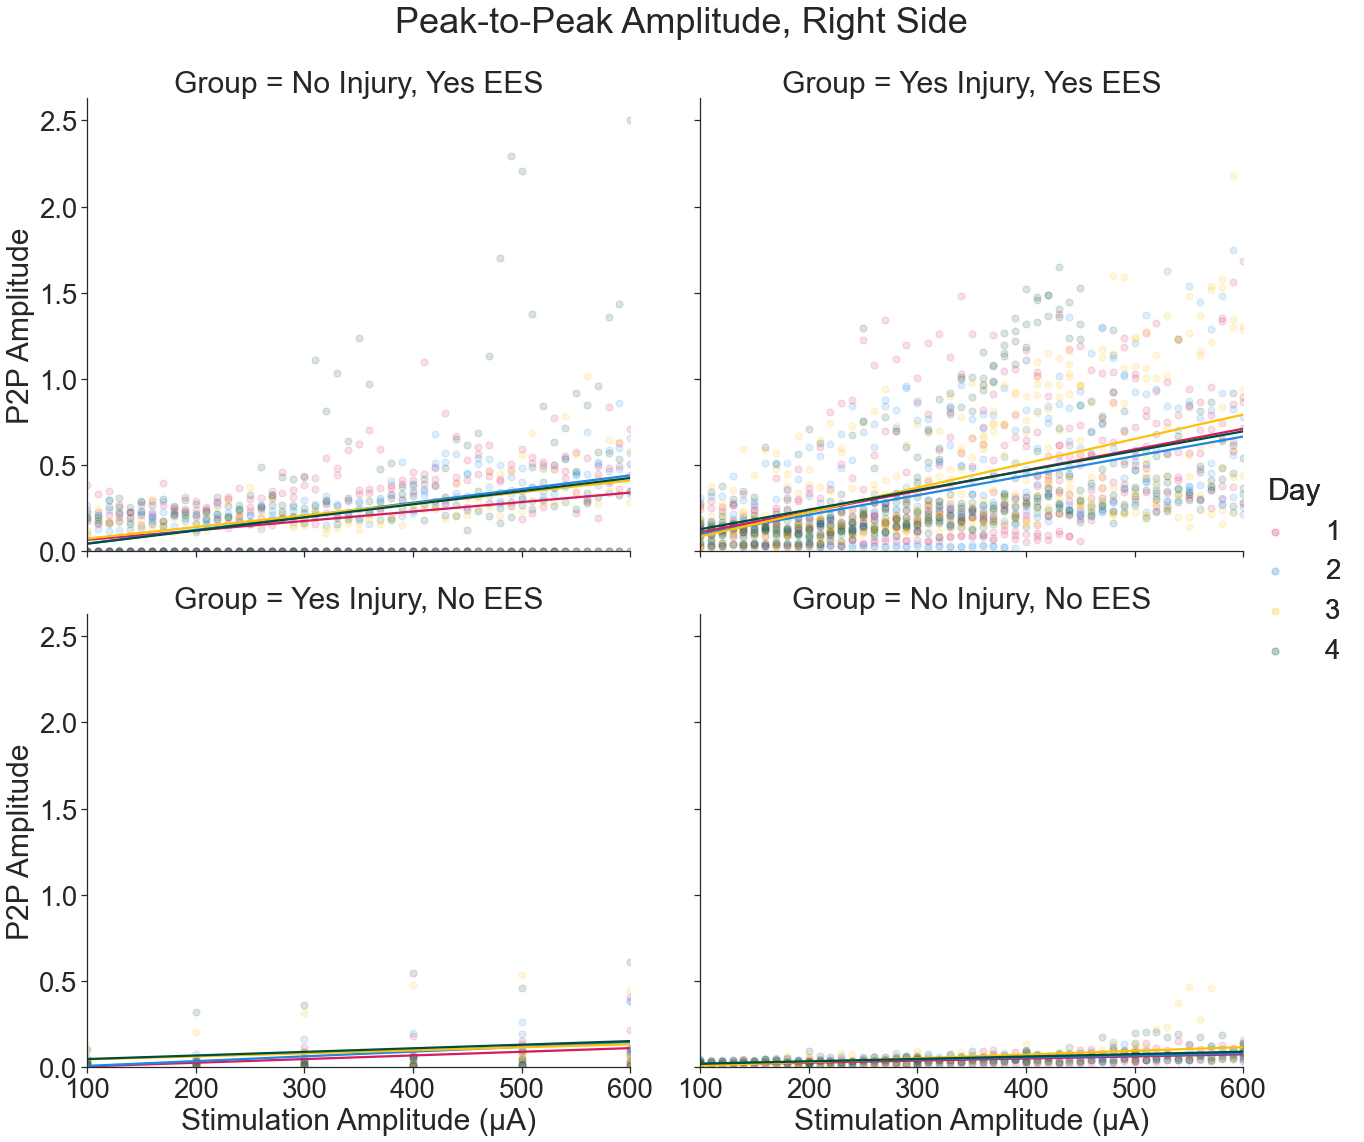

In [41]:
plt.figure(figsize=(24,12))
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette(sns.color_palette(colors))

g = sns.lmplot(x='Stim_Amp', y='Scalar_Original_Value', col='Group', hue='Day', 
                data=df_neilsen_scaled[(df_neilsen_scaled['Side']=='Right') 
                                                        & (df_neilsen_scaled['Time_Bin']=='1_to_21ms') 
                                                        & (df_neilsen_scaled['Metric']=='p2p')],
       col_wrap=2, order=1, ci=0, height=8,
       scatter_kws={"s": 50, "alpha": 0.15})

g.set(xlim=(100, None), ylim=(0, None))

g.set_axis_labels("Stimulation Amplitude (μA)", "P2P Amplitude")
g.add_legend()
g.fig.subplots_adjust(top=.90) # adjust the Figure in rp
g.fig.suptitle('Peak-to-Peak Amplitude, Right Side')
#g.savefig("D:\\Neilsen\\Neilsen_Figures\\right-p2p-scalar.pdf")

#### Area under the curve

- Area under the curve (AUC)
    - Scalar rescaled
    - Left and right sides
    - All time bins
    - All four groups
    - All four days
    - sns.lmplot

Text(0.5, 0.98, 'Area Under the Curve, Left Side')

<Figure size 1728x864 with 0 Axes>

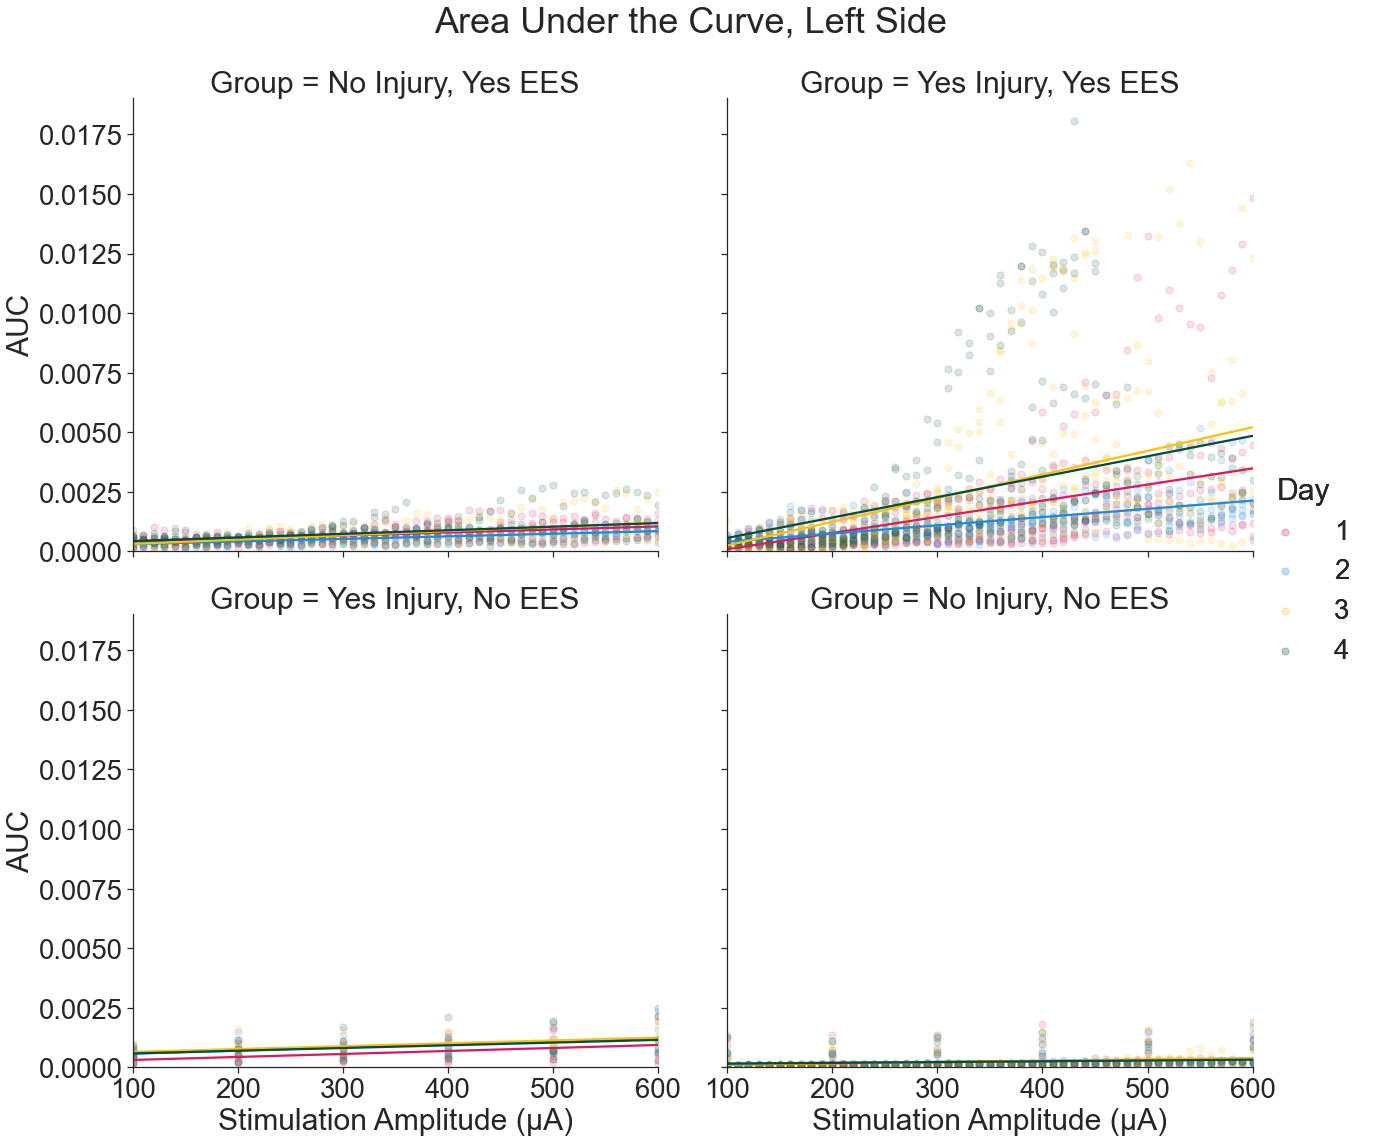

In [42]:
plt.figure(figsize=(24,12))
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()
sns.set_palette(sns.color_palette(colors))

g = sns.lmplot(x='Stim_Amp', y='Scalar_Original_Value', col='Group', hue='Day', 
                data=df_neilsen_scaled[(df_neilsen_scaled['Side']=='Left') 
                                                        & (df_neilsen_scaled['Time_Bin']=='1_to_21ms') 
                                                        & (df_neilsen_scaled['Metric']=='auc')],
       col_wrap=2, order=1, ci=0, height=8,
       scatter_kws={"s": 50, "alpha": 0.15})

g.set(xlim=(100, None), ylim=(0, None))


g.set_axis_labels("Stimulation Amplitude (μA)", "AUC")
g.add_legend()
g.fig.subplots_adjust(top=.90) # adjust the Figure in rp
g.fig.suptitle('Area Under the Curve, Left Side')
#g.savefig("D:\\Neilsen\\Neilsen_Figures\\left-auc-scalar.pdf")

Text(0.5, 0.98, 'Area Under the Curve, Right Side')

<Figure size 1728x864 with 0 Axes>

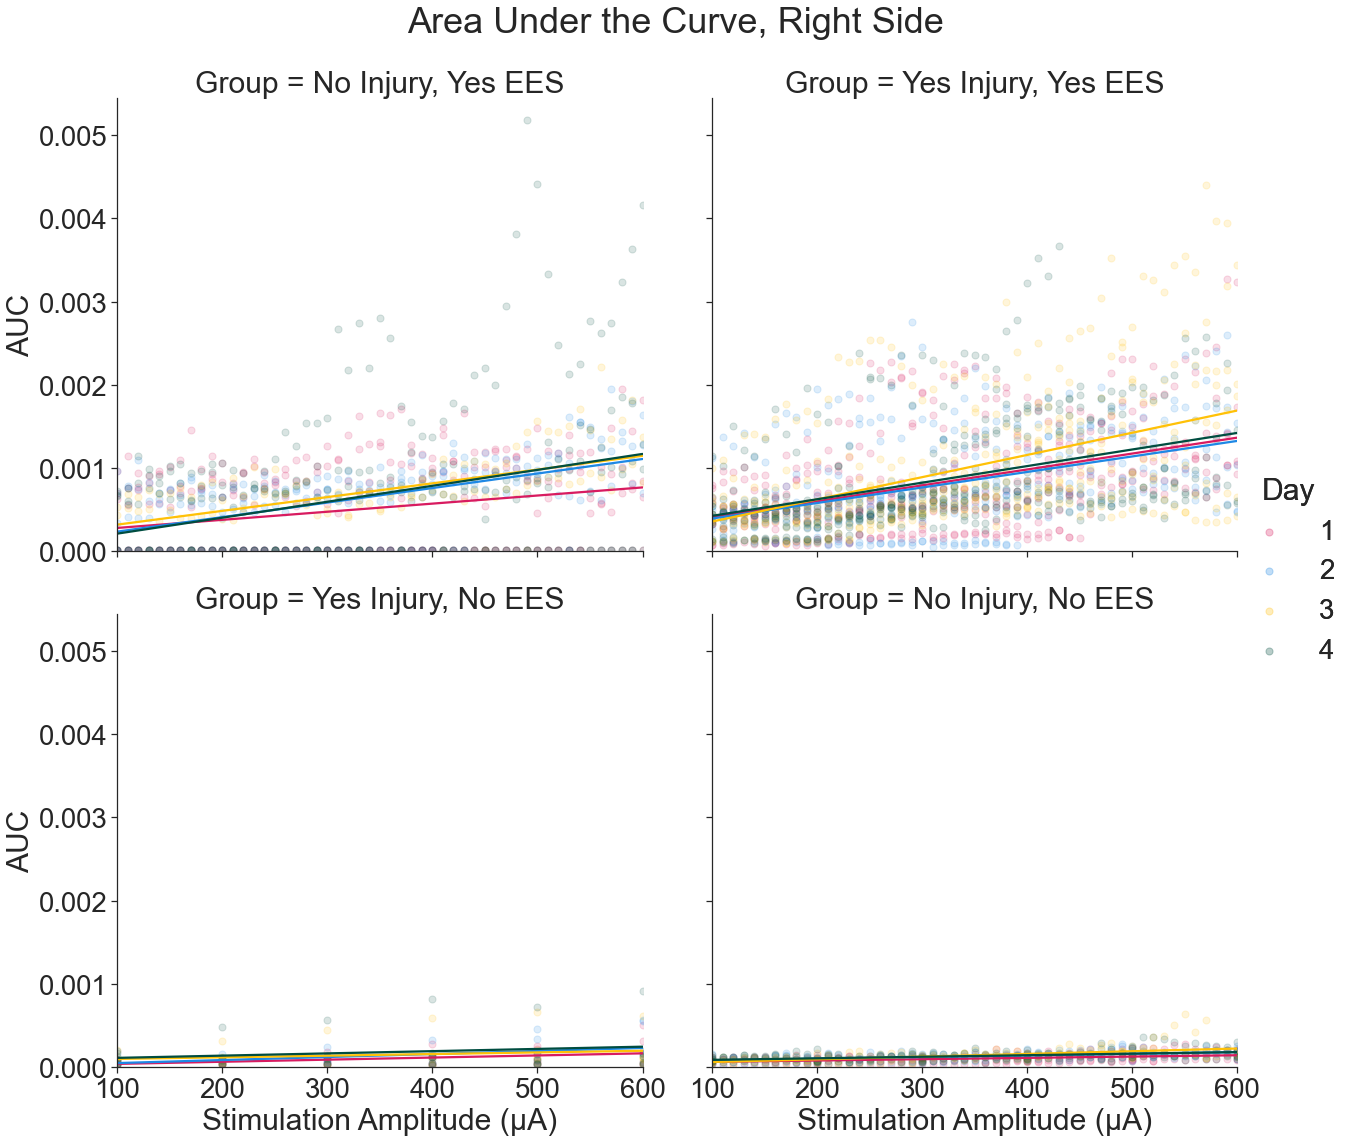

In [43]:
plt.figure(figsize=(24,12))
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()
sns.set_palette(sns.color_palette(colors))

g = sns.lmplot(x='Stim_Amp', y='Scalar_Original_Value', col='Group', hue='Day', 
                data=df_neilsen_scaled[(df_neilsen_scaled['Side']=='Right') 
                                                        & (df_neilsen_scaled['Time_Bin']=='1_to_21ms') 
                                                        & (df_neilsen_scaled['Metric']=='auc')],
       col_wrap=2, order=1, ci=0, height=8,
       scatter_kws={"s": 50, "alpha": 0.15})

g.set(xlim=(100, None), ylim=(0, None))


g.set_axis_labels("Stimulation Amplitude (μA)", "AUC")
g.add_legend()
g.fig.subplots_adjust(top=.90) # adjust the Figure in rp
g.fig.suptitle('Area Under the Curve, Right Side')
# g.savefig("D:\\Neilsen\\Neilsen_Figures\\right-auc-scalar.pdf")

#### Aggregate time bins

- Aggregate time bins
    - P2P and AUC
    - Rescaled and non-rescaled
    - Average values between 339 and 401 uA (this range captures all animals on all days)
    - Left and right sides
    - All time bins
    - All four groups
    - All four days
    - sns.violinplot



In [136]:
df_neilsen_scaled.head()

Animal  Day  Stim_Amp               Group  Side  Time_Bin Metric     Value  \
0    N01    1      10.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.040588   
1    N01    1      20.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.018412   
2    N01    1      30.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.035543   
3    N01    1      40.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.058105   
4    N01    1      50.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.073853   

   Scalar_Original_Value  Minmax_Original_Value  
0               0.040588               0.047042  
1               0.018412               0.021145  
2               0.035543               0.041150  
3               0.058105               0.067498  
4               0.073853               0.085888

In [135]:
df_timebin = df_neilsen_scaled.copy()
df_timebin['Scalar_Original_Value'] = df_timebin['Scalar_Original_Value']
df_timebin = df_timebin[(df_timebin['Time_Bin'] != '1_to_21ms') 
                                 & (df_timebin['Metric'] == 'p2p')
                                 & (df_timebin['Day'].isin([1,4]))
                                 ]
df_timebin.to_csv('D:\\Neilsen\\Dataframes\\df_timebin.csv')


In [44]:
df_neilsen_agg = df_neilsen_scaled.copy()


df_neilsen_agg = df_neilsen_agg.groupby(['Day', 'Group', 'Side', 'Stim_Amp', 'Time_Bin', 'Metric']).agg({'Value':'mean', 
                         'Scalar_Original_Value':'mean', 
                         'Minmax_Original_Value':'mean'}).reset_index() 
df_neilsen_agg.head()

Day              Group  Side  Stim_Amp    Time_Bin Metric     Value  \
0    1  No Injury, No EES  Left     100.0  13_to_17ms    auc  0.001089   
1    1  No Injury, No EES  Left     100.0  13_to_17ms    p2p  1.157746   
2    1  No Injury, No EES  Left     100.0  17_to_21ms    auc  0.000786   
3    1  No Injury, No EES  Left     100.0  17_to_21ms    p2p  0.957716   
4    1  No Injury, No EES  Left     100.0   1_to_21ms    auc  0.004315   

   Scalar_Original_Value  Minmax_Original_Value  
0               0.000115               0.088781  
1               0.121783               0.177270  
2               0.000086               0.069210  
3               0.103611               0.164857  
4               0.000461               0.378063

In [132]:
df_neilsen_agg.head()

Day              Group  Side  Stim_Amp    Time_Bin Metric     Value  \
0    1  No Injury, No EES  Left     100.0  13_to_17ms    auc  0.001089   
1    1  No Injury, No EES  Left     100.0  13_to_17ms    p2p  1.157746   
2    1  No Injury, No EES  Left     100.0  17_to_21ms    auc  0.000786   
3    1  No Injury, No EES  Left     100.0  17_to_21ms    p2p  0.957716   
4    1  No Injury, No EES  Left     100.0   1_to_21ms    auc  0.004315   

   Scalar_Original_Value  Minmax_Original_Value  
0               0.000115               0.088781  
1               0.121783               0.177270  
2               0.000086               0.069210  
3               0.103611               0.164857  
4               0.000461               0.378063

<Figure size 1728x1728 with 0 Axes>

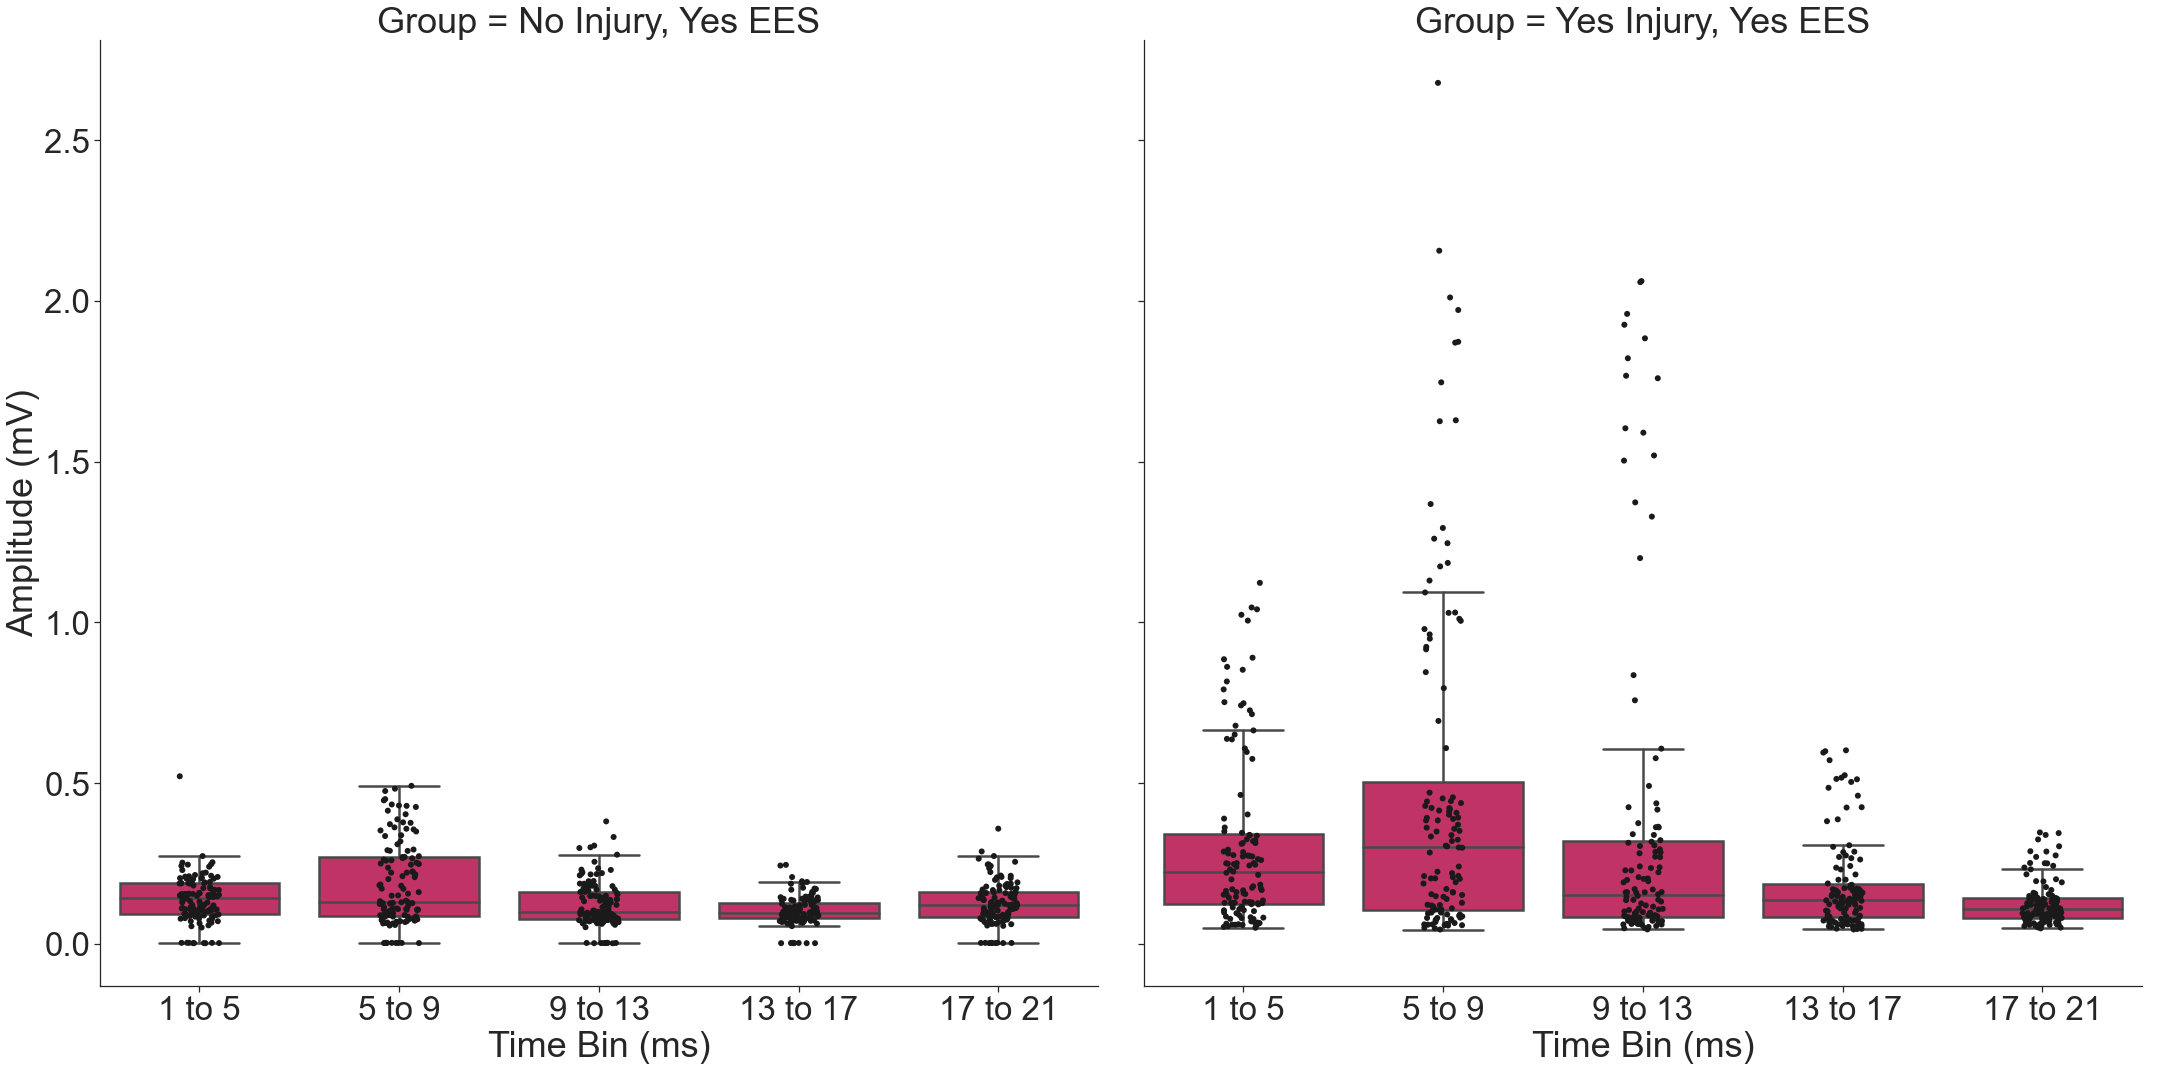

In [45]:
plt.figure(figsize=(24,24))
sns.set(font_scale=3)
sns.set_style("ticks")
sns.despine()
sns.set_palette(sns.color_palette(colors))

df_time_bin = df_neilsen_agg.copy()
df_time_bin['Scalar_Original_Value'] = df_time_bin['Scalar_Original_Value']*1000

g = sns.FacetGrid(df_time_bin[(df_time_bin['Time_Bin'] != '1_to_21ms') 
                                 & (df_time_bin['Metric'] != 'p2p')
                                 & (df_time_bin['Day'].isin([4]))
                                 & (df_time_bin['Group'].isin(['No Injury, Yes EES', 'Yes Injury, Yes EES']))],
                  col="Group",  height=15)

g.map_dataframe(sns.boxplot, x="Time_Bin",
                y="Scalar_Original_Value", 
                order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'],
                showfliers=False, linewidth=2.5, notch=False)
g.map_dataframe(sns.stripplot, x="Time_Bin",
                y="Scalar_Original_Value", 
                order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'], dodge=True, color='k', size=6)

g.set_axis_labels("Time Bin (ms)", "Amplitude (mV)")
g.add_legend()
g.set_xticklabels(['1 to 5','5 to 9','9 to 13','13 to 17','17 to 21'])
g.fig.subplots_adjust(top=.95) # adjust the Figure in rp
#g.savefig("D:\\Neilsen\\Neilsen_Figures\\erica-fig-may-5.png")

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\iangm\\Downloads\\timebin1.png'

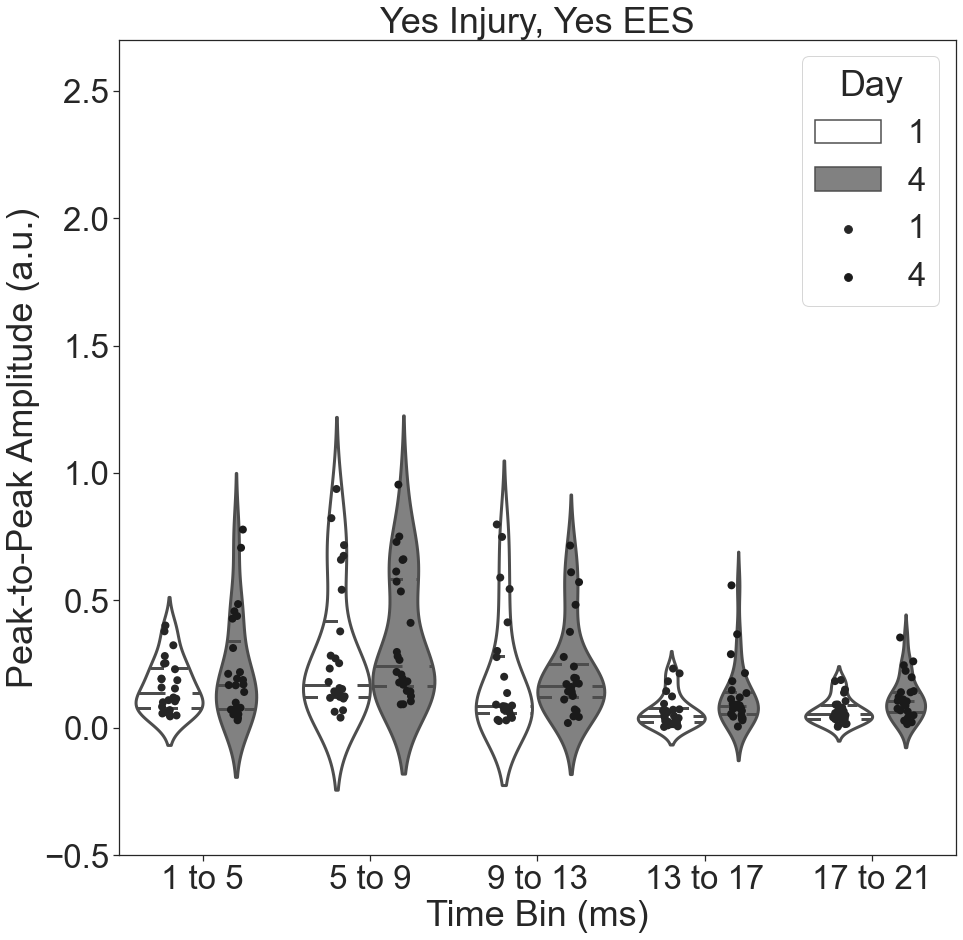

In [141]:
# LEFT SIDE

sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=3)
sns.set_style("ticks")
colors = ["#FFFFFF", "#818181"]
sns.set_palette(sns.color_palette(colors))



amps_compare = [100,200,300,400,500,600]
df_time_bin = df_neilsen_scaled.copy()
# df_time_bin['Scalar_Original_Value'] = df_time_bin['Scalar_Original_Value']*100

plot = df_time_bin[(df_time_bin['Time_Bin'] != '1_to_21ms') 
                                 & (df_time_bin['Metric'] == 'p2p')
                                 & (df_time_bin['Side'] == 'Left')
                                 & (df_time_bin['Day'].isin([1,4]))
                                 & (df_time_bin['Stim_Amp']>200)
                                 & (df_time_bin['Group']=='Yes Injury, No EES')
                                 ]

sns.stripplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
              dodge=True,jitter=True,color='k', size=8,
              order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])

ax = sns.violinplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', linewidth=3,
                 inner='quartile', order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])
patch_violinplot()

ax.set(ylim=(-0.5, 2.7))


ax.set(title='Yes Injury, Yes EES', xlabel='Time Bin (ms)', ylabel='Peak-to-Peak Amplitude (a.u.)')
ax.set_xticklabels(['1 to 5','5 to 9','9 to 13','13 to 17','17 to 21'])

fig=ax.get_figure()
# fig.savefig("D:\\timebin.png", dpi=300) #desktop
fig.savefig("C:\\Users\\iangm\\Downloads\\timebin1.png", dpi=300) #laptop

[Text(0, 0, '1 to 5'),
 Text(1, 0, '5 to 9'),
 Text(2, 0, '9 to 13'),
 Text(3, 0, '13 to 17'),
 Text(4, 0, '17 to 21')]

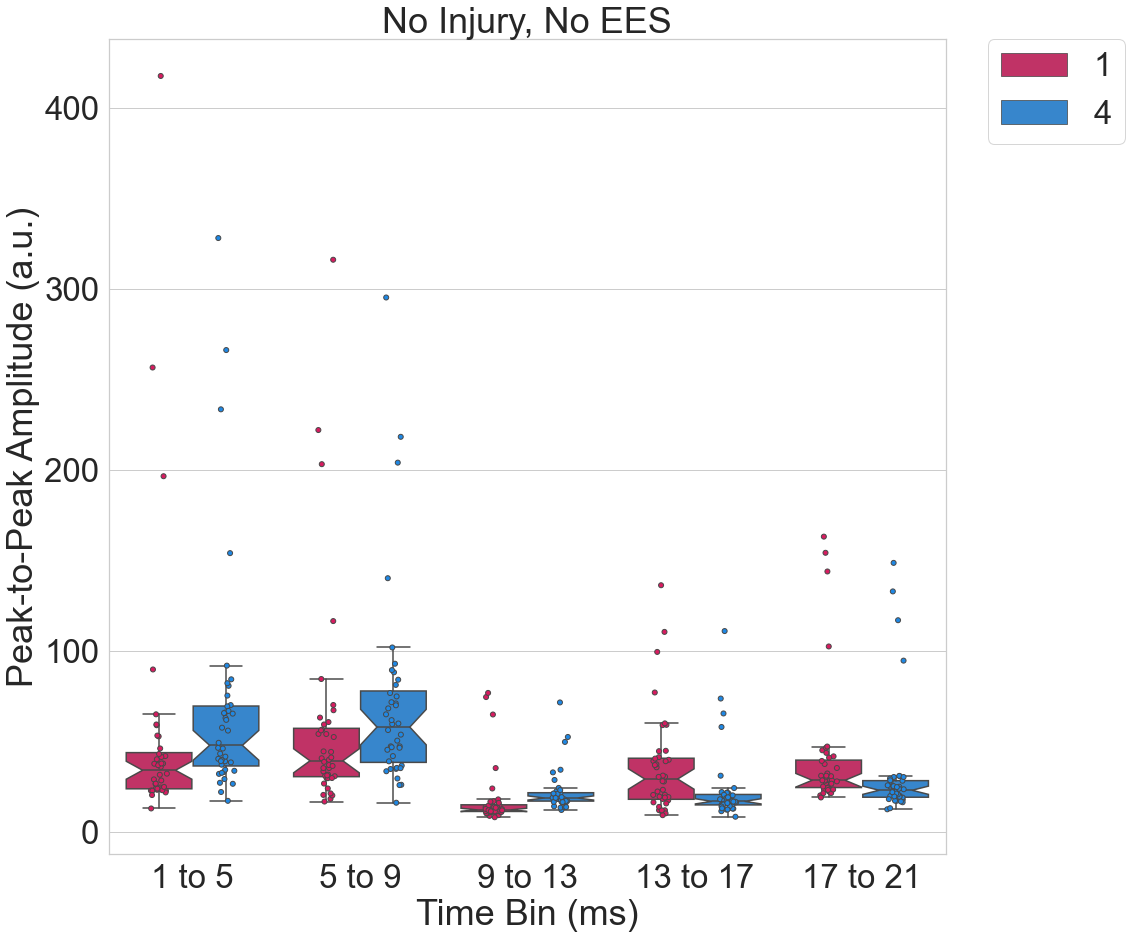

In [46]:
# LEFT SIDE

sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=3)
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette(colors))

amps_compare = [100,200,300,400,500,600]
df_time_bin = df_neilsen_agg.copy()
df_time_bin['Scalar_Original_Value'] = df_time_bin['Scalar_Original_Value']*1000

plot = df_time_bin[(df_time_bin['Time_Bin'] != '1_to_21ms') 
                                 & (df_time_bin['Metric'] == 'p2p')
                                 & (df_time_bin['Side'] == 'Left')
                                 & (df_time_bin['Day'].isin([1,4]))
                                 & (df_time_bin['Stim_Amp']>200)
                                 & (df_time_bin['Group']=='No Injury, No EES')
                                 ]

sns.stripplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
              dodge=True,jitter=True,linewidth=1,edgecolor='gray',
              order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])

ax = sns.boxplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
                 showfliers=False, notch=True, order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])


# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set(title='No Injury, No EES', xlabel='Time Bin (ms)', ylabel='Peak-to-Peak Amplitude (a.u.)')
ax.set_xticklabels(['1 to 5','5 to 9','9 to 13','13 to 17','17 to 21'])

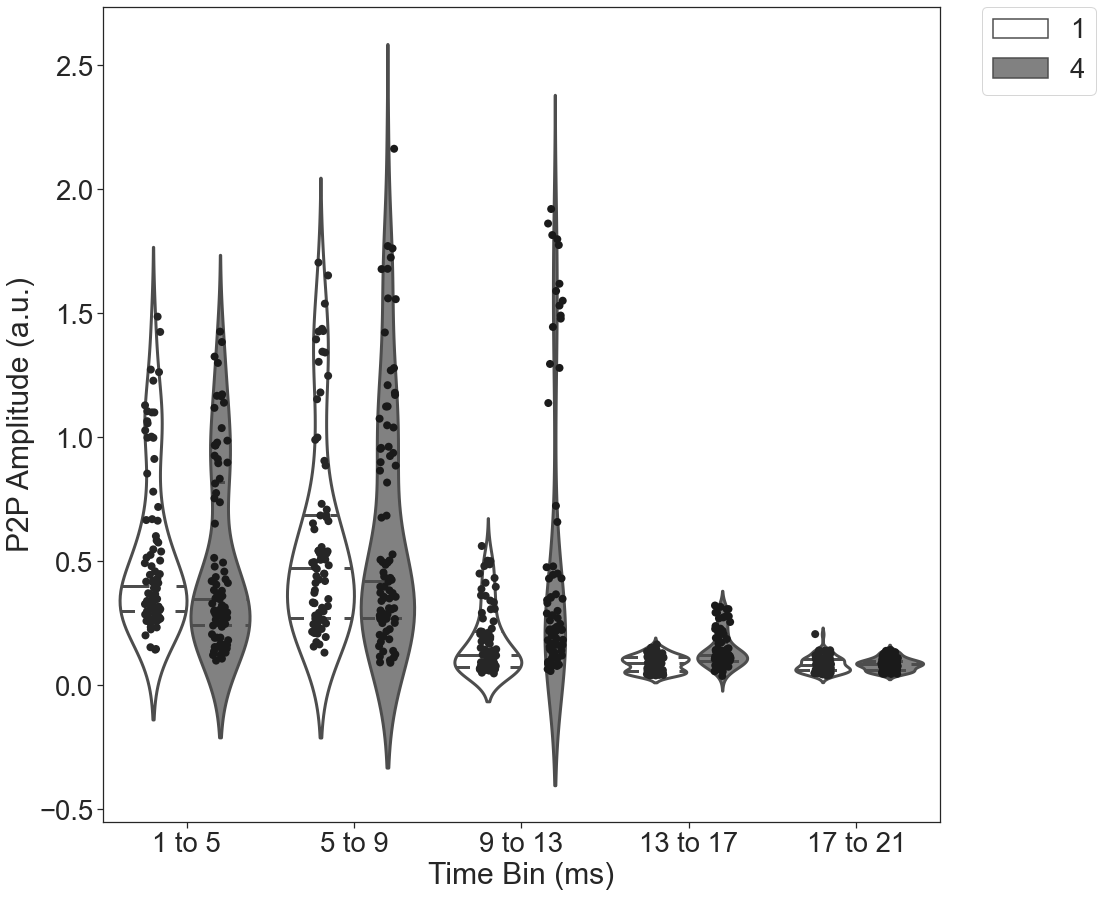

In [140]:
sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=2.5)
sns.set_style("ticks")
colors = ["#FFFFFF", "#818181"]
sns.set_palette(sns.color_palette(colors))
sns.cubehelix_palette(start=2, rot=0, dark=0.4, light=1)



amps_compare = [100,200,300,400,500,600]
df_time_bin = df_neilsen_agg.copy()
# df_time_bin['Scalar_Original_Value'] = df_time_bin['Scalar_Original_Value']*100

plot = df_time_bin[(df_time_bin['Time_Bin'] != '1_to_21ms') 
                                 & (df_time_bin['Metric'] == 'p2p')
                                 & (df_time_bin['Day'].isin([1,4]))
                                 & (df_time_bin['Stim_Amp']>200)
                                 & (df_time_bin['Group']=='Yes Injury, Yes EES')
                                 ]

sns.stripplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
              dodge=True,jitter=True,color='k', size=8,
              order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])

ax = sns.violinplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', linewidth=3,
                 inner='quartile', order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])
# sns.stripplot(data=df_motor_threshold[(df_motor_threshold['Day'].isin(4) & (df_motor_threshold['Side']=='Left')], x="Therapy", y="Motor_Threshold", 
#              color='k',size=10,dodge=True,jitter=True,order=['No Therapy', 'Yes Therapy'])

# ax = sns.violinplot(data=df_motor_threshold[(df_motor_threshold['Day']==4) & (df_motor_threshold['Side']=='Left')], x="Therapy", 
#                     y="Motor_Threshold",
#                  order=['No Therapy', 'Yes Therapy'], inner="quartile")

# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
#ax.set(ylim=(-0.5, 2.7))


handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set(xlabel='Time Bin (ms)', ylabel='P2P Amplitude (a.u.)')
ax.set_xticklabels(['1 to 5','5 to 9','9 to 13','13 to 17','17 to 21'])

fig=ax.get_figure()
fig.savefig("C:\\Users\\Ian\\Downloads\\motor-threshold.png", dpi=300) #desktop
# fig.savefig("C:\\Users\\iangm\\Downloads\\timebin2.png", dpi=300) #laptop

[Text(0, 0, '1 to 5'),
 Text(1, 0, '5 to 9'),
 Text(2, 0, '9 to 13'),
 Text(3, 0, '13 to 17'),
 Text(4, 0, '17 to 21')]

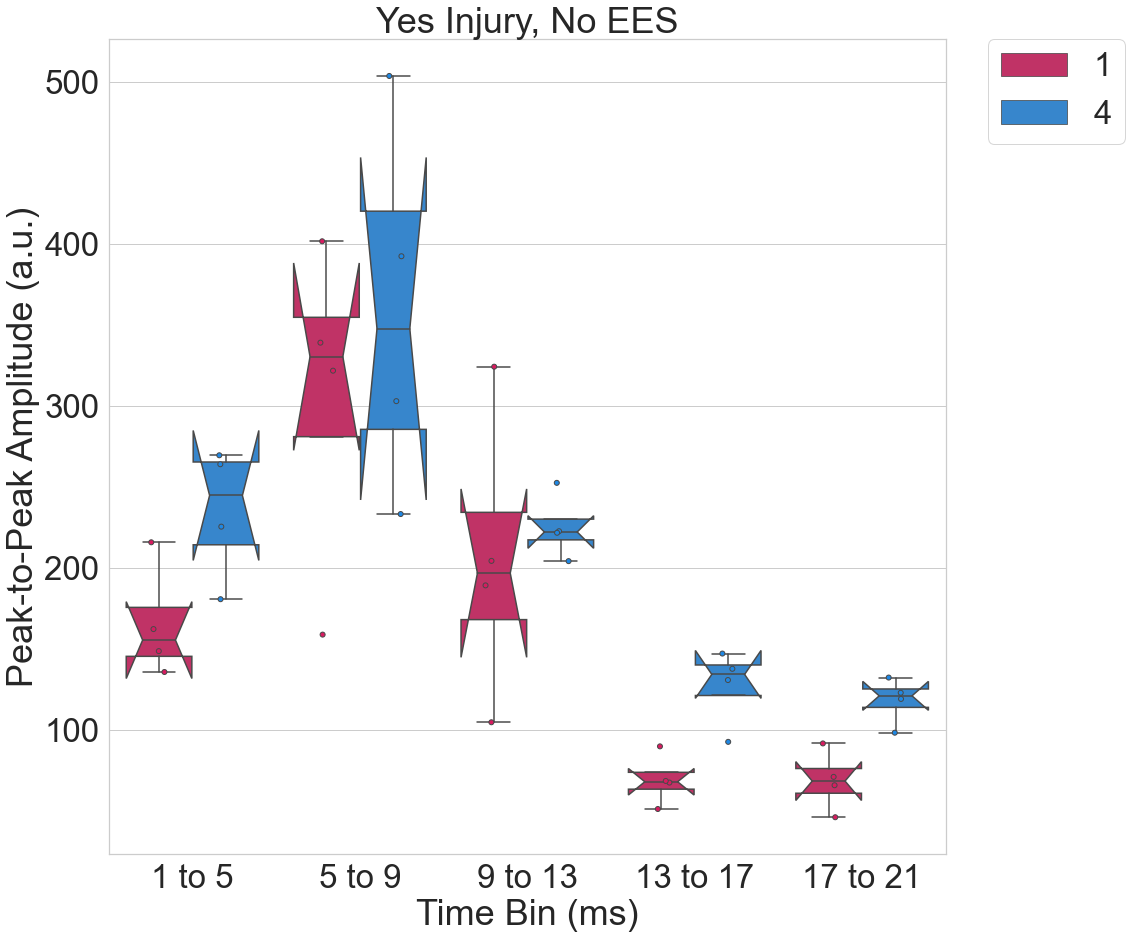

In [47]:
# LEFT SIDE

sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=3)
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette(colors))

amps_compare = [100,200,300,400,500,600]
df_time_bin = df_neilsen_agg.copy()
df_time_bin['Scalar_Original_Value'] = df_time_bin['Scalar_Original_Value']*1000

plot = df_time_bin[(df_time_bin['Time_Bin'] != '1_to_21ms') 
                                 & (df_time_bin['Metric'] == 'p2p')
                                 & (df_time_bin['Side'] == 'Left')
                                 & (df_time_bin['Day'].isin([1,4]))
                                 & (df_time_bin['Stim_Amp']>200)
                                 & (df_time_bin['Group']=='Yes Injury, No EES')
                                 ]

sns.stripplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
              dodge=True,jitter=True,linewidth=1,edgecolor='gray',
              order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])

ax = sns.boxplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
                 showfliers=False,notch=True,  order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])


# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
.set(title='Yes Injury, No EES', xlabel='Time Bin (ms)', ylabel='Peak-to-Peak Amplitude (a.u.)')
ax.set_xticklabels(['1 to 5','5 to 9','9 to 13','13 to 17','17 to 21'])

[Text(0, 0, '1 to 5'),
 Text(1, 0, '5 to 9'),
 Text(2, 0, '9 to 13'),
 Text(3, 0, '13 to 17'),
 Text(4, 0, '17 to 21')]

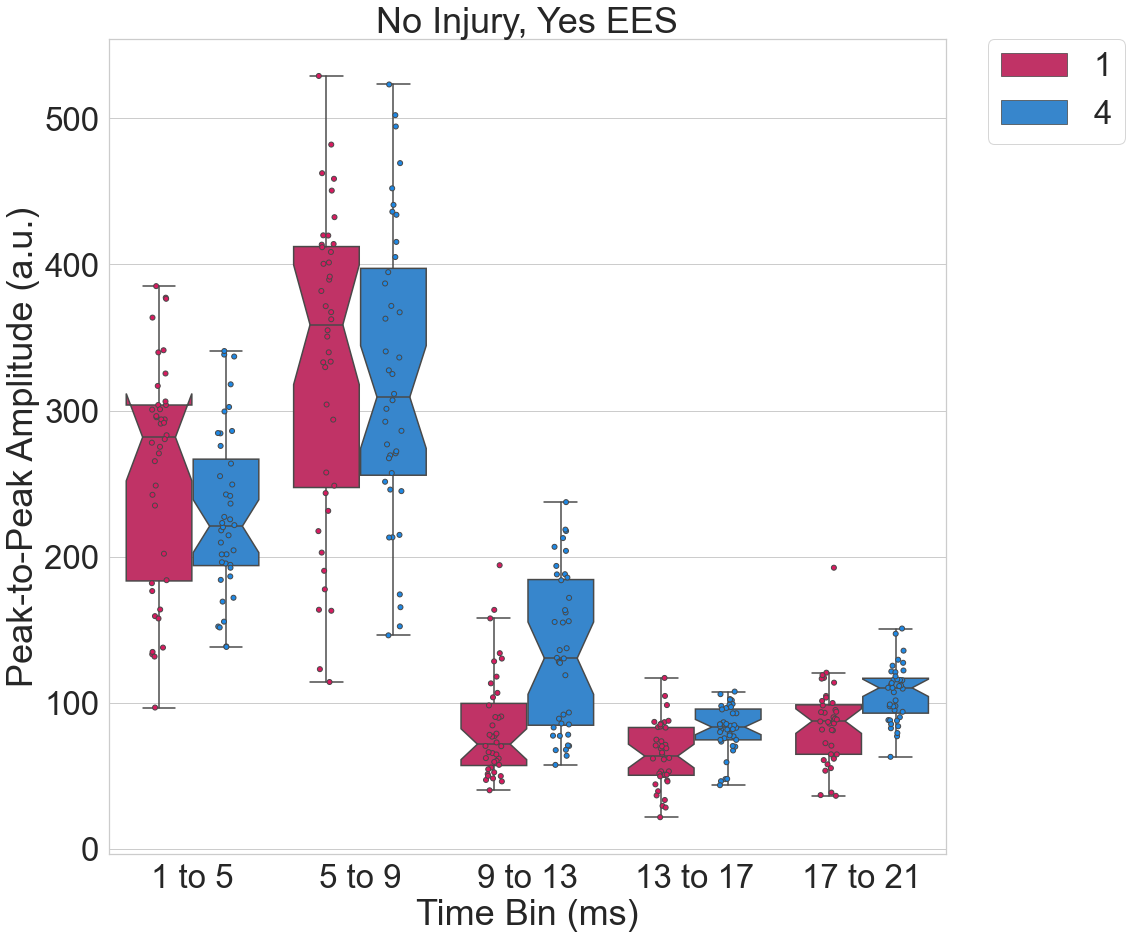

In [48]:
# LEFT SIDE

sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=3)
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette(colors))

amps_compare = [100,200,300,400,500,600]
df_time_bin = df_neilsen_agg.copy()
df_time_bin['Scalar_Original_Value'] = df_time_bin['Scalar_Original_Value']*1000

plot = df_time_bin[(df_time_bin['Time_Bin'] != '1_to_21ms') 
                                 & (df_time_bin['Metric'] == 'p2p')
                                 & (df_time_bin['Side'] == 'Left')
                                 & (df_time_bin['Day'].isin([1,4]))
                                 & (df_time_bin['Stim_Amp']>200)
                                 & (df_time_bin['Group']=='No Injury, Yes EES')
                                 ]

sns.stripplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
              dodge=True,jitter=True,linewidth=1,edgecolor='gray',
              order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])

ax = sns.boxplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
                 showfliers=False,notch=True,  order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])


# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set(title='No Injury, Yes EES', xlabel='Time Bin (ms)', ylabel='Peak-to-Peak Amplitude (a.u.)')
ax.set_xticklabels(['1 to 5','5 to 9','9 to 13','13 to 17','17 to 21'])

In [117]:
df_neilsen_agg.head()

Day              Group  Side  Stim_Amp    Time_Bin Metric     Value  \
0    1  No Injury, No EES  Left     100.0  13_to_17ms    auc  0.001089   
1    1  No Injury, No EES  Left     100.0  13_to_17ms    p2p  1.157746   
2    1  No Injury, No EES  Left     100.0  17_to_21ms    auc  0.000786   
3    1  No Injury, No EES  Left     100.0  17_to_21ms    p2p  0.957716   
4    1  No Injury, No EES  Left     100.0   1_to_21ms    auc  0.004315   

   Scalar_Original_Value  Minmax_Original_Value  
0               0.000115               0.088781  
1               0.121783               0.177270  
2               0.000086               0.069210  
3               0.103611               0.164857  
4               0.000461               0.378063

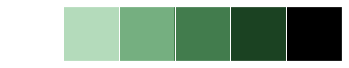

In [110]:
sns.palplot(sns.cubehelix_palette(start=5, rot=0, dark=0, light=1))


In [116]:
test = plot.copy()
test = test[(test['Time_Bin']=='9_to_13ms') &
           (test['Scalar_Original_Value']>0.6)]
test.head()

Day                Group  Side  Stim_Amp   Time_Bin Metric     Value  \
15755    4  Yes Injury, Yes EES  Left     290.0  9_to_13ms    p2p  0.658804   
15767    4  Yes Injury, Yes EES  Left     300.0  9_to_13ms    p2p  0.724000   
15779    4  Yes Injury, Yes EES  Left     310.0  9_to_13ms    p2p  1.138304   
15791    4  Yes Injury, Yes EES  Left     320.0  9_to_13ms    p2p  1.295814   
15803    4  Yes Injury, Yes EES  Left     330.0  9_to_13ms    p2p  1.279866   

       Scalar_Original_Value  Minmax_Original_Value  
15755               0.658804               0.094019  
15767               0.724000               0.098915  
15779               1.138304               0.155933  
15791               1.295814               0.170780  
15803               1.279866               0.168621

[Text(0, 0, '1 to 5'),
 Text(1, 0, '5 to 9'),
 Text(2, 0, '9 to 13'),
 Text(3, 0, '13 to 17'),
 Text(4, 0, '17 to 21')]

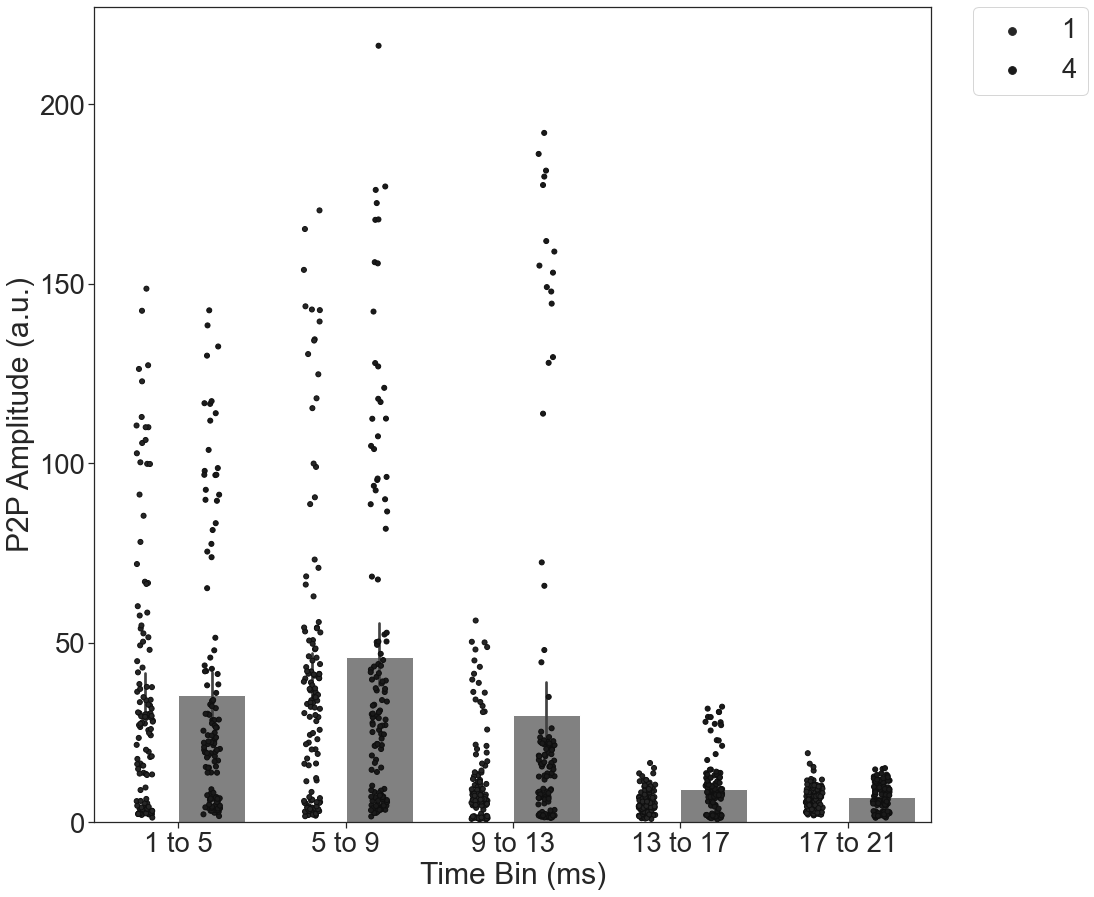

In [50]:

sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette(sns.color_palette(colors))

amps_compare = [100,200,300,400,500,600]
df_time_bin = df_neilsen_agg.copy()
df_time_bin['Scalar_Original_Value'] = df_time_bin['Scalar_Original_Value']*100

plot = df_time_bin[(df_time_bin['Time_Bin'] != '1_to_21ms') 
                                 & (df_time_bin['Metric'] == 'p2p')
                                 & (df_time_bin['Side'] == 'Left')
                                 & (df_time_bin['Day'].isin([1,4]))
                                 & (df_time_bin['Stim_Amp']>200)
                                 ]

sns.stripplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
              dodge=True,jitter=True,linewidth=1,color='k',
              order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])

ax = sns.barplot(data=plot, x="Time_Bin", y="Scalar_Original_Value", hue='Day', 
                 order=['1_to_5ms', '5_to_9ms', '9_to_13ms', '13_to_17ms', '17_to_21ms'])
# sns.stripplot(data=df_motor_threshold[(df_motor_threshold['Day'].isin(4) & (df_motor_threshold['Side']=='Left')], x="Therapy", y="Motor_Threshold", 
#              color='k',size=10,dodge=True,jitter=True,order=['No Therapy', 'Yes Therapy'])

# ax = sns.violinplot(data=df_motor_threshold[(df_motor_threshold['Day']==4) & (df_motor_threshold['Side']=='Left')], x="Therapy", 
#                     y="Motor_Threshold",
#                  order=['No Therapy', 'Yes Therapy'], inner="quartile")

# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.set(xlabel='Time Bin (ms)', ylabel='P2P Amplitude (a.u.)')
ax.set_xticklabels(['1 to 5','5 to 9','9 to 13','13 to 17','17 to 21'])


#### Threshold changes

- Threshold changes
    - Marissa is sending these data
    - You may need to adjust the values to account for recording differences (like you did with stim. amplitude)
    - Percent change in motor threshold
    - Left and right sides
    - All time bins
    - All four groups
    - All four days (d1 to d2, d1 to d3, d1 to d4)
    - sns.violinplot

In [51]:
motor_threshold_path = 'D:\\Neilsen\\neilsen_motor_threshold_data.csv'
df_motor_threshold = pd.read_csv(motor_threshold_path)
add_group(df_motor_threshold)
df_motor_threshold.to_csv('D:\\Neilsen\\Dataframes\\df_motor_threshold.csv')
df_motor_threshold.head()

Day Animal  Side  Motor_Threshold                Group
0    1    N01  Left              150   No Injury, Yes EES
1    1    N04  Left              290   No Injury, Yes EES
2    1    N05  Left              200   No Injury, Yes EES
3    1    N09  Left              110  Yes Injury, Yes EES
4    1    N10  Left              150  Yes Injury, Yes EES

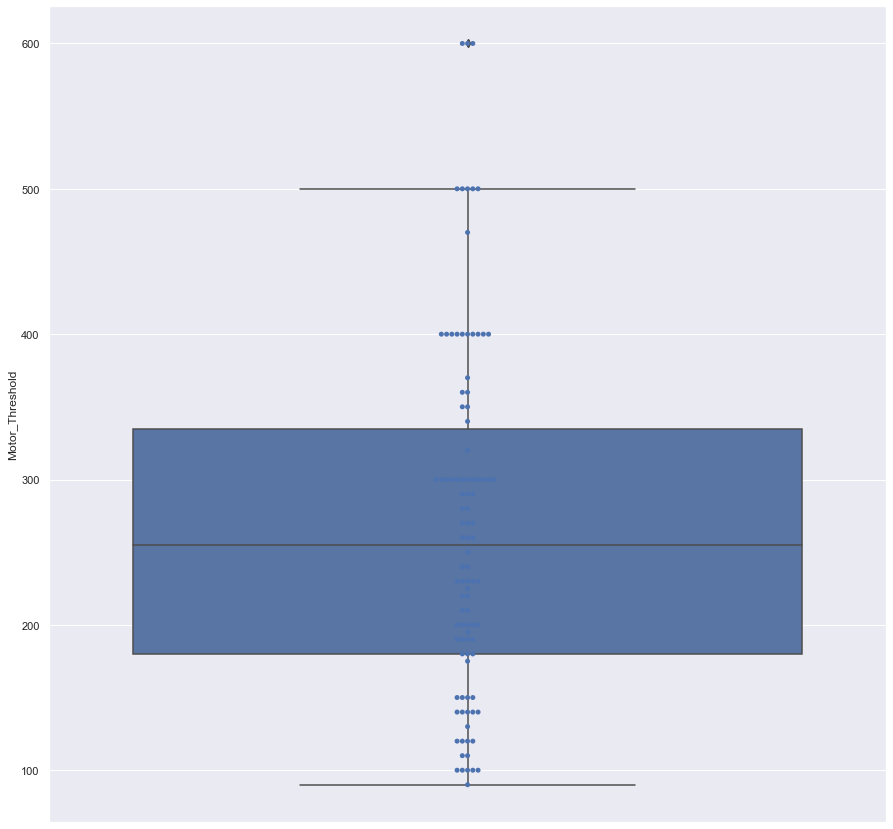

In [126]:
sns.set_theme()
ax = sns.swarmplot(y="Motor_Threshold", data=df_motor_threshold)

ax = sns.boxplot(y="Motor_Threshold", data=df_motor_threshold)


In [52]:
df_motor_threshold['Injury'] = np.where(df_motor_threshold['Group'].str.contains("Yes Injury"), "Yes Injury", "No Injury")
df_motor_threshold['Therapy'] = np.where(df_motor_threshold['Group'].str.contains("Yes EES"), "Yes Therapy", "No Therapy")
df_motor_threshold.head()

Day Animal  Side  Motor_Threshold                Group      Injury  \
0    1    N01  Left              150   No Injury, Yes EES   No Injury   
1    1    N04  Left              290   No Injury, Yes EES   No Injury   
2    1    N05  Left              200   No Injury, Yes EES   No Injury   
3    1    N09  Left              110  Yes Injury, Yes EES  Yes Injury   
4    1    N10  Left              150  Yes Injury, Yes EES  Yes Injury   

       Therapy  
0  Yes Therapy  
1  Yes Therapy  
2  Yes Therapy  
3  Yes Therapy  
4  Yes Therapy

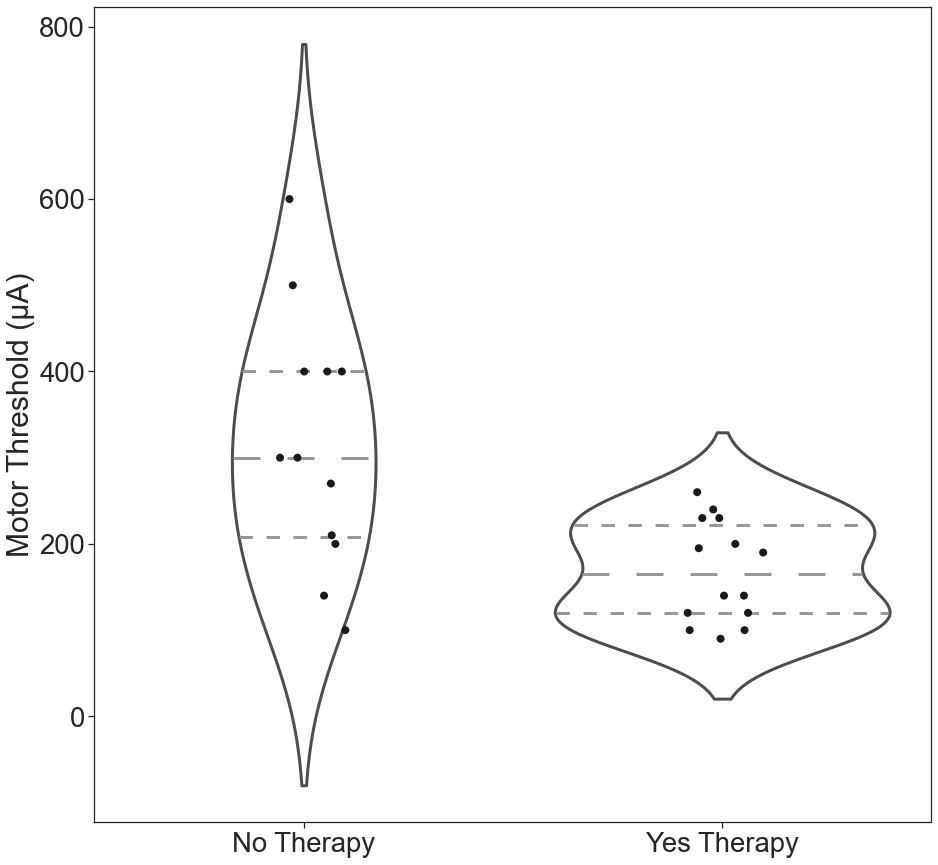

In [53]:
# LEFT SIDE

sns.set(rc={'figure.figsize':(15,15)})
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.set_palette(sns.color_palette(colors))

sns.stripplot(data=df_motor_threshold[(df_motor_threshold['Day'].isin([4]))
             & (df_motor_threshold['Side']=='Left')], x="Therapy", y="Motor_Threshold", 
             color='k',size=8,dodge=True,jitter=True,order=['No Therapy', 'Yes Therapy'])

ax = sns.violinplot(data=df_motor_threshold[(df_motor_threshold['Day']==4) & (df_motor_threshold['Side']=='Left')], x="Therapy", 
                    y="Motor_Threshold", color='white', linewidth=3,
                 order=['No Therapy', 'Yes Therapy'], inner="quartile")

patch_violinplot()


# Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
# l = plt.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)




ax.set(title=None, xlabel=None, ylabel='Motor Threshold (µA)')

fig=ax.get_figure()
fig.savefig("D:\\motor-threshold.png", dpi=300)

### LMEM Plots

In [54]:
#
#
#
# these are being done in R Studio
#
#
#

# Methods Figures

#### Stimulus-triggered averages over time

<ipython-input-55-8d0414f163c2>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_signal_plot['Day'] = df_signal_plot['Day'].replace({1:'Day 0', 2:'Day 1', 3:'Day 2', 4:'Day 3'})


<Figure size 1080x1080 with 0 Axes>

<Figure size 864x432 with 0 Axes>

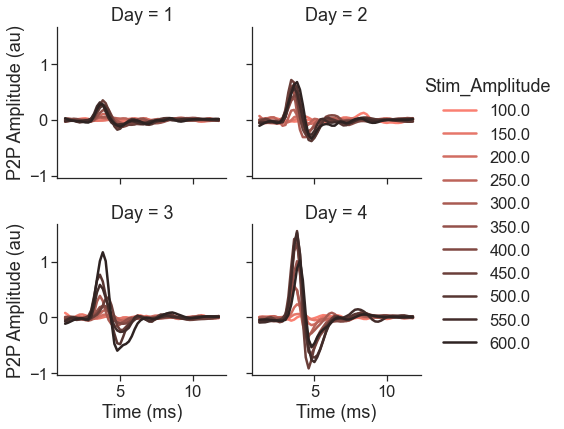

In [55]:
sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.despine()
plt.figure(figsize=(12,6))
stimlist = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600]
animallist = ['N27']
daylist=[1,2,3,4]

df_example = df_sta_noart.copy()
df_example = df_example.rename(columns={'Day_Stim':'Day'})
colors = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']
#sns.set_palette(sns.color_palette(colors))
df_signal_plot = df_example[(df_example['Stim_Amplitude'].isin(stimlist)) & (df_example['Time'] < 30) 
                               & (df_example['Animal'].isin(animallist)) 
                               & (df_example['Day'].isin(daylist))
                               & (df_example['Side'] == 'Left')
                               & (df_example['Time'] < 12)]



g = sns.FacetGrid(df_signal_plot, 
                  col='Day', palette='dark:salmon_r', hue='Stim_Amplitude', col_wrap=2)

g.map_dataframe(sns.lineplot, x='Time', y='STA_Amplitude', linewidth=2.5)
g.set_axis_labels('Time (ms)', 'P2P Amplitude (au)')
g.add_legend()
g.savefig("D:\\sta_over_time.png", dpi=300)

df_signal_plot['Day'] = df_signal_plot['Day'].replace({1:'Day 0', 2:'Day 1', 3:'Day 2', 4:'Day 3'})
df_signal_plot.to_csv('D:\\Neilsen\\Dataframes\\df_signal_plot.csv')



### Peak-to-peak (p2p) amplitude analysis

In [56]:
# make dataframe from the raw data and the scaled data to check if distribution is preserved later

df_p2p_scaled = df_sta_scaled.copy()
df_p2p = df_sta_noart.copy()
df_p2p.head()

Animal  Day_Stim  Side  Stim_Amplitude  STA_Amplitude  Time
6     N01         1  Left            10.0      -0.009423   1.2
7     N01         1  Left            10.0      -0.003745   1.4
8     N01         1  Left            10.0       0.007764   1.6
9     N01         1  Left            10.0       0.020294   1.8
10    N01         1  Left            10.0       0.022230   2.0

#### Calclated p2p amplitude

In [57]:
df_p2p = df_p2p.groupby(['Animal', 'Day_Stim', 'Stim_Amplitude'])['STA_Amplitude'].apply(lambda x: x.max() - x.min()).reset_index().rename(columns={'STA_Amplitude':'p2p_amplitude'})
df_p2p_scaled = df_p2p_scaled.groupby(['Animal', 'Day_Stim', 'Stim_Amplitude'])['STA_Amplitude'].apply(lambda x: x.max() - x.min()).reset_index().rename(columns={'STA_Amplitude':'p2p_amplitude_scaled'})


#### Convert all p2p amplitudes into ratios of the animal's max p2p amplitude over all 4 days

In [58]:
# Convert all p2p amplitudes into ratios of the animal's max p2p amplitude

### YOU MAY HAVE TO GROUP THEM ON SIDE AS WELL FOR EACH ANIMAL
 
df_p2p_ratio_max = df_p2p.merge(df_p2p.groupby(['Animal'])['p2p_amplitude'].max(), on='Animal', how='left')
df_p2p_ratio_max['p2p_amplitude_ratio_max'] = df_p2p_ratio_max['p2p_amplitude_x'] / df_p2p_ratio_max['p2p_amplitude_y']
df_p2p_ratio_max = df_p2p_ratio_max.drop(columns=['p2p_amplitude_x', 'p2p_amplitude_y'])

#### Add group information to dataframes

In [59]:
add_group(df_p2p)
add_group(df_p2p_scaled)
add_group(df_p2p_ratio_max)
df_p2p_ratio_max.head()

Animal  Day_Stim  Stim_Amplitude  p2p_amplitude_ratio_max  \
0    N01         1            10.0                 0.045521   
1    N01         1            20.0                 0.046879   
2    N01         1            30.0                 0.049342   
3    N01         1            40.0                 0.063211   
4    N01         1            50.0                 0.089499   

                Group  
0  No Injury, Yes EES  
1  No Injury, Yes EES  
2  No Injury, Yes EES  
3  No Injury, Yes EES  
4  No Injury, Yes EES

In [60]:
df_p2p_scaled.head()

Animal  Day_Stim  Stim_Amplitude  p2p_amplitude_scaled               Group
0    N01         1            10.0              0.044218  No Injury, Yes EES
1    N01         1            15.0                   NaN  No Injury, Yes EES
2    N01         1            20.0              0.045537  No Injury, Yes EES
3    N01         1            25.0                   NaN  No Injury, Yes EES
4    N01         1            30.0              0.047929  No Injury, Yes EES

#### Make plots to compare the distribution of p2p, p2p_scaled, p2p_ratio_max

In [61]:
df_neilsen_scaled.head()

Animal  Day  Stim_Amp               Group  Side  Time_Bin Metric     Value  \
0    N01    1      10.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.040588   
1    N01    1      20.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.018412   
2    N01    1      30.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.035543   
3    N01    1      40.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.058105   
4    N01    1      50.0  No Injury, Yes EES  Left  1_to_5ms    p2p  0.073853   

   Scalar_Original_Value  Minmax_Original_Value  
0               0.040588               0.047042  
1               0.018412               0.021145  
2               0.035543               0.041150  
3               0.058105               0.067498  
4               0.073853               0.085888

<Figure size 1080x1080 with 0 Axes>

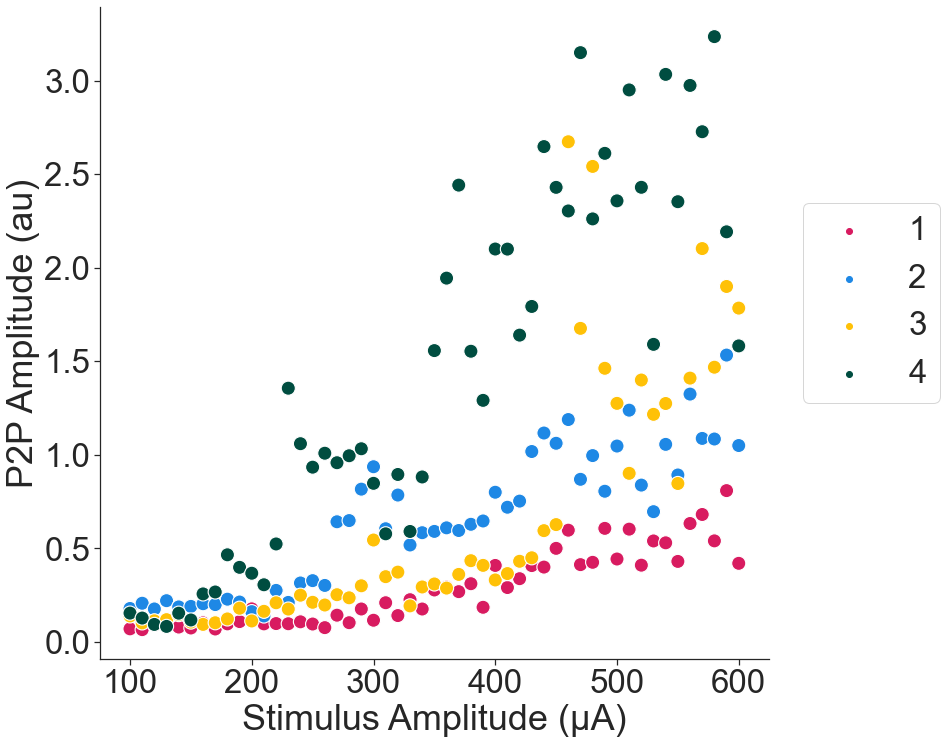

In [62]:
# Representative plot for presentations

sns.set(font_scale=3)
sns.set_style("ticks")
sns.despine()
plt.figure(figsize=(12,12))
colors = ['#D81B60', '#1E88E5', '#FFC107', '#004D40']
sns.set_palette(sns.color_palette(colors))

df_points_plot = df_neilsen_scaled[(df_neilsen_scaled['Side']=='Left') 
                                                        & (df_neilsen_scaled['Time_Bin']=='1_to_21ms') 
                                                        & (df_neilsen_scaled['Metric']=='p2p')
                                                        & (df_neilsen_scaled['Animal']=='N27')]
df_points_plot.to_csv('D:\\Neilsen\\Dataframes\\df_points_plot.csv')

ax = sns.scatterplot(data=df_points_plot, 
                x='Stim_Amp', y='Scalar_Original_Value', 
                     palette=sns.color_palette(colors), hue='Day', s=200)
ax.set(xlabel='Stimulus Amplitude (μA)', ylabel='P2P Amplitude (au)')
# ax.spines['left'].set_linewidth(5)
# ax.spines['bottom'].set_linewidth(5)
# ax.xaxis.set_tick_params(width=5)
# ax.yaxis.set_tick_params(width=5)
sns.despine()

for lh in ax.legend().legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [150] 
ax.legend().set_title('Day')
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.)


ax.figure.savefig("D:\\N27_representative.png", dpi=300)

<Figure size 1080x1080 with 0 Axes>

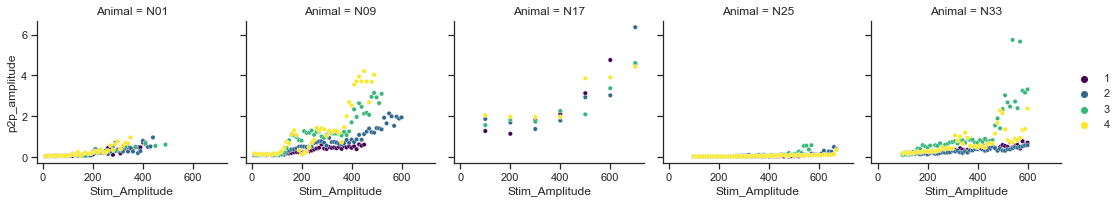

In [63]:
sns.set(font_scale=1)
sns.set_style("ticks")
sns.despine()

animals = ['N01','N09','N17','N25','N33']

g = sns.FacetGrid(df_p2p[df_p2p['Animal'].isin(animals)], col="Animal")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_amplitude", 'Day_Stim', palette='viridis',s=20).add_legend())

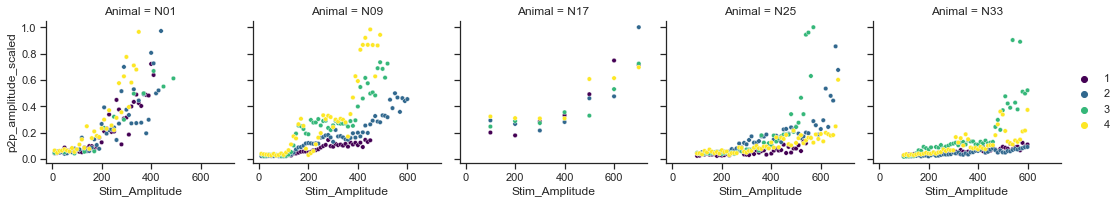

In [64]:
g = sns.FacetGrid(df_p2p_scaled[df_p2p_scaled['Animal'].isin(animals)], col="Animal")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_amplitude_scaled", 'Day_Stim', palette='viridis',s=20).add_legend())


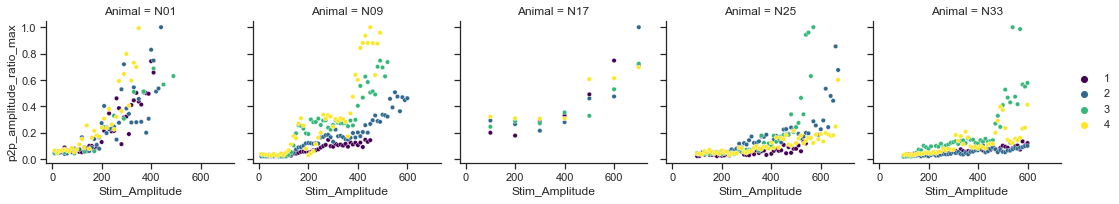

In [65]:
g = sns.FacetGrid(df_p2p_ratio_max[df_p2p_ratio_max['Animal'].isin(animals)], col="Animal")
g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_amplitude_ratio_max", 'Day_Stim', palette='viridis',s=20).add_legend())


#### Fit lines by group and day to visualize change over time (and stim amplitude) for each group

In [66]:
# plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
# sns.set_style("ticks")
# sns.despine()
# df_nice_plot = df_p2p_scaled.copy()
# df_nice_plot = df_nice_plot.rename(columns={"Day_Stim": "Day", "p2p_amplitude_scaled": "Normalized Peak to Peak Amplitude", 
#                                                     "Stim_Amplitude": "Stimulus Amplitude (μA)"})
# ax = sns.lmplot(x="Stimulus Amplitude (μA)", y="Normalized Peak to Peak Amplitude", hue="Day", data=df_nice_plot[df_nice_plot['Group']=='Yes Injury, Yes Therapy'],
#            order=1, ci=95, palette="tab10", height=8,
#            scatter_kws={"s": 50, "alpha": 0.3})
# ax.set(ylim=(0, None))
# ax.savefig("D:\\t32-data-blitz.png")


# plt.figure(figsize=(24,12))
# sns.set(font_scale=2)
# sns.set_style("darkgrid")
# sns.despine()
# df_nice_plot = df_p2p_scaled.copy()
# df_nice_plot = df_nice_plot.rename(columns={"Day_Stim": "Day", "p2p_amplitude_scaled": "Normalized Peak to Peak Amplitude", 
#                                                     "Stim_Amplitude": "Stimulus Amplitude (μA)"})
# ax = sns.lmplot(x="Stimulus Amplitude (μA)", y="Normalized Peak to Peak Amplitude", col="Group", hue="Day", data=df_nice_plot,
#            col_wrap=2, order=1, ci=95, palette="muted", height=8,
#            scatter_kws={"s": 50, "alpha": 0.3})
# ax.savefig("D:\\groupmainfig.png")

In [67]:
df_p2p.head()

Animal  Day_Stim  Stim_Amplitude  p2p_amplitude               Group
0    N01         1            10.0       0.043851  No Injury, Yes EES
1    N01         1            20.0       0.045159  No Injury, Yes EES
2    N01         1            30.0       0.047532  No Injury, Yes EES
3    N01         1            40.0       0.060892  No Injury, Yes EES
4    N01         1            50.0       0.086215  No Injury, Yes EES

<Figure size 1728x864 with 0 Axes>

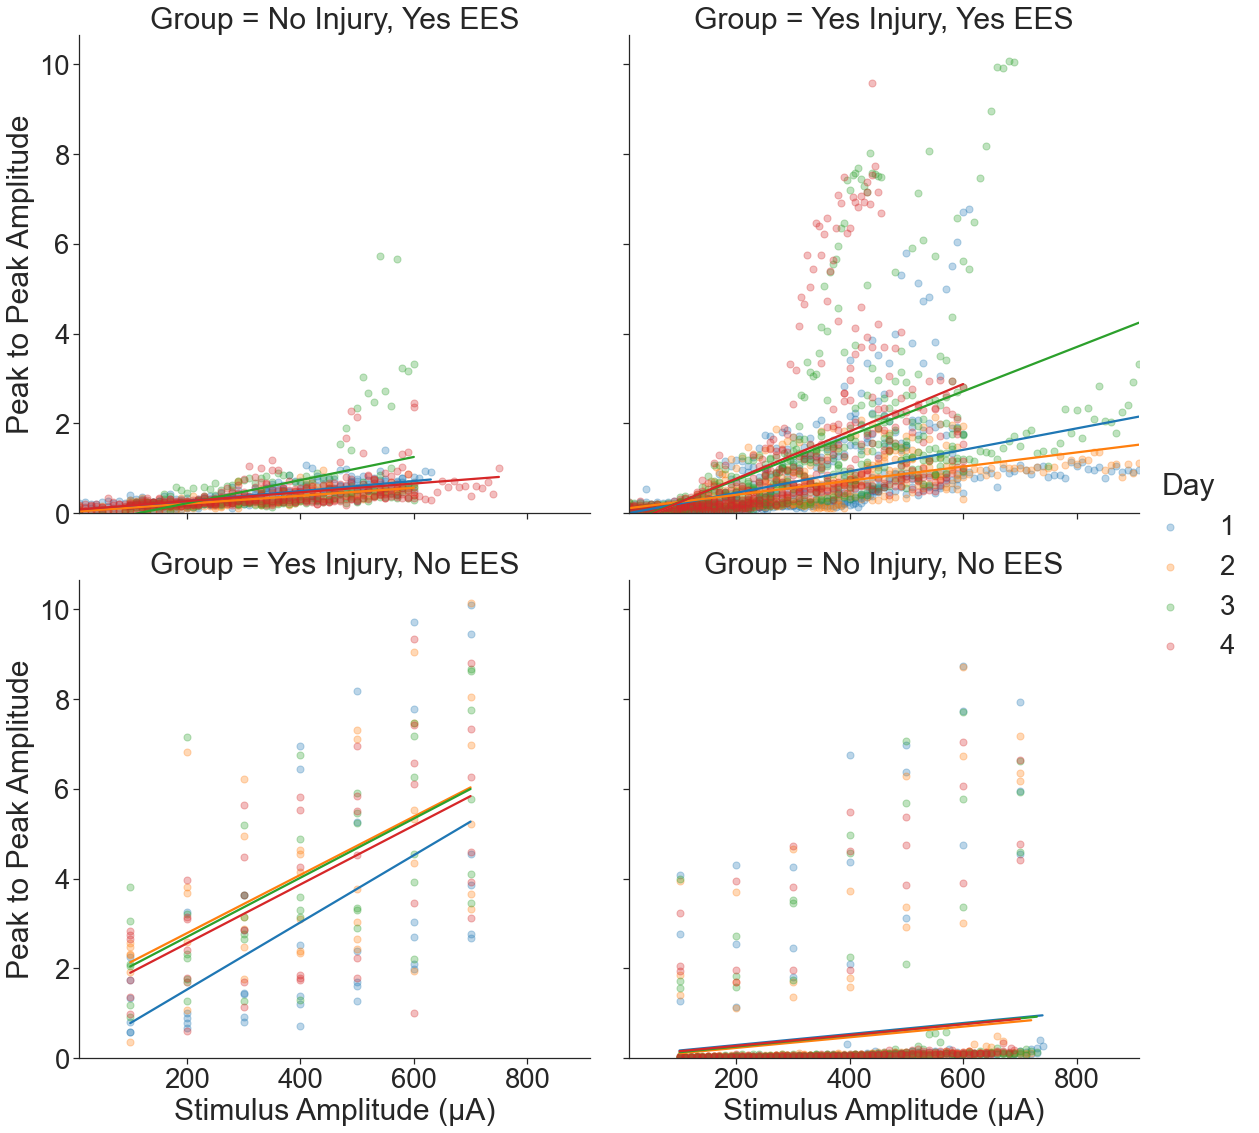

In [68]:
plt.figure(figsize=(24,12))
sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()

# df_nice_plot = df_p2p_scaled.copy()
# df_nice_plot = df_nice_plot.rename(columns={"Day_Stim": "Day", "p2p_amplitude_scaled": "Normalized Peak to Peak Amplitude", 
#                                                     "Stim_Amplitude": "Stimulus Amplitude (μA)"})
# ax = sns.lmplot(x="Stimulus Amplitude (μA)", y="Normalized Peak to Peak Amplitude", col="Group", hue="Day", data=df_nice_plot,
#            col_wrap=2, order=1, ci=95, palette="tab10", height=8,
#            scatter_kws={"s": 50, "alpha": 0.3})
# ax.set(ylim=(0, None))
# ax.savefig("D:\\t32-data-blitz.png")

df_nice_plot = df_p2p.copy()
df_nice_plot = df_nice_plot.rename(columns={"Day_Stim": "Day", "p2p_amplitude": "Peak to Peak Amplitude", 
                                                    "Stim_Amplitude": "Stimulus Amplitude (μA)"})
ax = sns.lmplot(x="Stimulus Amplitude (μA)", y="Peak to Peak Amplitude", col="Group", hue="Day", data=df_nice_plot,
           col_wrap=2, order=1, ci=0, palette="tab10", height=8,
           scatter_kws={"s": 50, "alpha": 0.3})
ax.set(ylim=(0, None))


#### Exploration of # hours before stim variable

In [69]:
# add column of # hours before stim for each animal
recent_animals = ['N27','N28','N29','N30','N31','N32','N33']

# set 0 as default for all animals
df_p2p_scaled["Hours_Stim"] = 0

# recent animals got 12h stim before MEPs after baseline day
df_p2p_scaled.loc[(df_p2p_scaled['Animal'].isin(recent_animals)) & (df_p2p_scaled['Day_Stim'] > 1), 'Hours_Stim'] = 12

# N01
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N01') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 5
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N01') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 7
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N01') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 23

# N04
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N04') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 7
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N04') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 23
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N04') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 1.5

# N05
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N05') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 7
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N05') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 23
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N05') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 20

# N09
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N09') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 14
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N09') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 21
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N09') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 22

# N10
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N10') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 20
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N10') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 22
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N10') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 14

# N11
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N11') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 21
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N11') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 22
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N11') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 22

# N13
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N13') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 24
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N13') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 28
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N13') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 28

# N34
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N34') & (df_p2p_scaled['Day_Stim'] == 2), 'Hours_Stim'] = 22
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N34') & (df_p2p_scaled['Day_Stim'] == 3), 'Hours_Stim'] = 22
df_p2p_scaled.loc[(df_p2p_scaled['Animal'] == 'N34') & (df_p2p_scaled['Day_Stim'] == 4), 'Hours_Stim'] = 22




#### Compare day 1 and day 4 max p2p amplitude for each group

In [70]:
df_avg_p2p = df_p2p_scaled.copy()
df_avg_p2p = df_avg_p2p[df_avg_p2p['Day_Stim'].isin([1,4])]
df_avg_p2p = df_avg_p2p.drop(columns=['Stim_Amplitude', 'Hours_Stim'])
df_mean = df_avg_p2p.groupby(['Day_Stim', 'Animal', 'Group'])['p2p_amplitude_scaled'].agg('mean').reset_index()
df_mean.head()
#df_avg_p2p.to_csv('D:\\df_avg_p2p.csv')

Day_Stim Animal                Group  p2p_amplitude_scaled
0         1    N01   No Injury, Yes EES              0.229875
1         1    N04   No Injury, Yes EES              0.451542
2         1    N05   No Injury, Yes EES              0.156468
3         1    N09  Yes Injury, Yes EES              0.074048
4         1    N10  Yes Injury, Yes EES              0.212962

<Figure size 1728x1728 with 0 Axes>

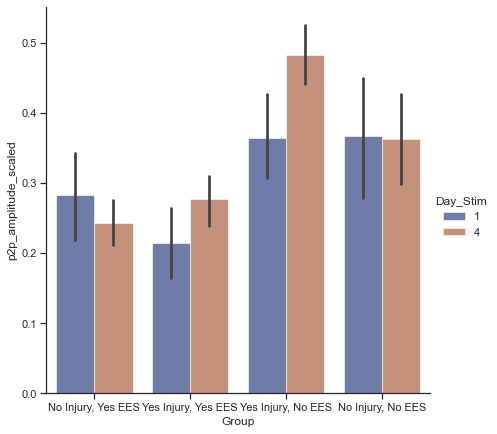

In [71]:
plt.figure(figsize=(24,24))
sns.set(font_scale=1)
sns.set_style("ticks")
sns.despine()

sns.catplot(
    data=df_mean, kind="bar",
    x="Group", y="p2p_amplitude_scaled", hue="Day_Stim",
    ci=68, palette="dark", alpha=.6, height=6
)

# sns.boxplot(x="Group", y="p2p_amplitude_scaled",
#             hue="Day_Stim",
#             data=df_avg_p2p)

#### Day 1 to day 4 percent change in max and mean p2p

In [72]:
df_d1d4_pchange = df_p2p_scaled.copy()
df_d1d4_pchange = df_d1d4_pchange[(df_d1d4_pchange['Day_Stim'].isin([1,4])) & (df_d1d4_pchange['Stim_Amplitude'].between(300,500))]

df_d1d4_pchange = df_d1d4_pchange.groupby(['Group', 'Day_Stim', 'Animal'])['p2p_amplitude_scaled'].agg('median').reset_index()
df_d1d4_pchange = df_d1d4_pchange.pivot(index=['Animal','Group'], columns='Day_Stim', values='p2p_amplitude_scaled').reset_index()
df_d1d4_pchange = df_d1d4_pchange.rename(columns={1: 'one', 4: 'four'})
df_d1d4_pchange['d1d4_pchange'] = ((df_d1d4_pchange['four'].sub(df_d1d4_pchange['one'])).div(df_d1d4_pchange["one"])).mul(100)
df_d1d4_pchange = df_d1d4_pchange.drop(columns=['one', 'four'])
df_d1d4_pchange.to_csv('D:\\df_d1d4_pchange.csv')

#### Threshold
At what amplitude did the animal hit 50% of its all time max?

In [73]:
df_p2p_scaled.head()

Animal  Day_Stim  Stim_Amplitude  p2p_amplitude_scaled               Group  \
0    N01         1            10.0              0.044218  No Injury, Yes EES   
1    N01         1            15.0                   NaN  No Injury, Yes EES   
2    N01         1            20.0              0.045537  No Injury, Yes EES   
3    N01         1            25.0                   NaN  No Injury, Yes EES   
4    N01         1            30.0              0.047929  No Injury, Yes EES   

   Hours_Stim  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0

In [74]:
# df_p2p_scaled.groupby(['Animal', 'Day']).p2p_amplitude_scaled.agg('max')

# df_p2p_scaled.loc[df_p2p_scaled['p2p_amplitude_scaled']>0.5]['Stim_Amplitude'].min()

df_threshold = df_p2p_scaled.copy()
df_threshold = df_threshold[(df_threshold['Day_Stim'].isin([1,4]))]
df_threshold = df_threshold.pivot(index=['Animal','Group','Stim_Amplitude'], columns='Day_Stim', values='p2p_amplitude_scaled').reset_index()
df_threshold = df_threshold.rename(columns={1: 'one', 4: 'four'})
df_threshold['min_stim_1'] = df_threshold['Stim_Amplitude'].where(df_threshold['one'] > 0.25).groupby(df_threshold['Animal']).transform('min')
df_threshold['min_stim_4'] = df_threshold['Stim_Amplitude'].where(df_threshold['four'] > 0.25).groupby(df_threshold['Animal']).transform('min')
df_threshold = df_threshold.drop(columns=['one','four','Stim_Amplitude'])
df_threshold = df_threshold.rename_axis(None, axis=1)
df_threshold = df_threshold.drop_duplicates()

df_threshold.head(50)

Animal                Group  min_stim_1  min_stim_4
0       N01   No Injury, Yes EES       230.0       210.0
139     N04   No Injury, Yes EES        60.0        60.0
278     N05   No Injury, Yes EES       350.0       380.0
417     N09  Yes Injury, Yes EES         NaN       160.0
556     N10  Yes Injury, Yes EES       390.0       400.0
695     N11  Yes Injury, Yes EES       180.0       250.0
834     N13  Yes Injury, Yes EES         NaN       295.0
973     N14   Yes Injury, No EES       200.0       100.0
1112    N15   Yes Injury, No EES       400.0       200.0
1251    N16   Yes Injury, No EES       300.0       100.0
1390    N17    No Injury, No EES       300.0       100.0
1529    N19    No Injury, No EES       100.0       300.0
1668    N20    No Injury, No EES       100.0       100.0
1807    N21   Yes Injury, No EES       300.0       400.0
1946    N22   Yes Injury, No EES       600.0       100.0
2085    N23   Yes Injury, No EES       600.0       100.0
2224    N24    No Injury, No EES       360.0       510.0
2363    N25    No Injury, No EES         NaN       670.0
2502    N26    No Injury, No EES       270.0       200.0
2641    N27  Yes Injury, Yes EES         NaN       230.0
2780    N28  Yes Injury, Yes EES       420.0       320.0
2919    N30  Yes Injury, Yes EES       190.0       330.0
3058    N31   No Injury, Yes EES       100.0       130.0
3197    N32   No Injury, Yes EES       100.0       120.0
3336    N33   No Injury, Yes EES         NaN       480.0
3475    N34  Yes Injury, Yes EES       390.0       350.0

In [75]:
# sns.catplot(
#     data=df_threshold, kind="bar",
#     x="Group", y="p2p_amplitude_scaled", hue="Day_Stim",
#     ci=68, palette="dark", alpha=.6, height=6
# )

#### Check linearity assumption with residual plot

In [76]:
# for all 4 groups and all 4 days, make stim vs p2p plot to check linearity

# multivariate normal. histogram or a Q-Q-Plot. Kolmogorov-Smirnov test.  
# When the data is not normally distributed a non-linear transformation (e.g., log-transformation) might fix this issue.

#### Updated plots for Otto meeting 3/17

In [77]:
df_p2p_scaled = df_p2p_scaled.dropna()

                             OLS Regression Results                             
Dep. Variable:     p2p_amplitude_scaled   R-squared:                       0.587
Model:                              OLS   Adj. R-squared:                  0.579
Method:                   Least Squares   F-statistic:                     69.72
Date:                  Mon, 06 Sep 2021   Prob (F-statistic):           5.60e-11
Time:                          21:53:47   Log-Likelihood:                 30.110
No. Observations:                    51   AIC:                            -56.22
Df Residuals:                        49   BIC:                            -52.36
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.167

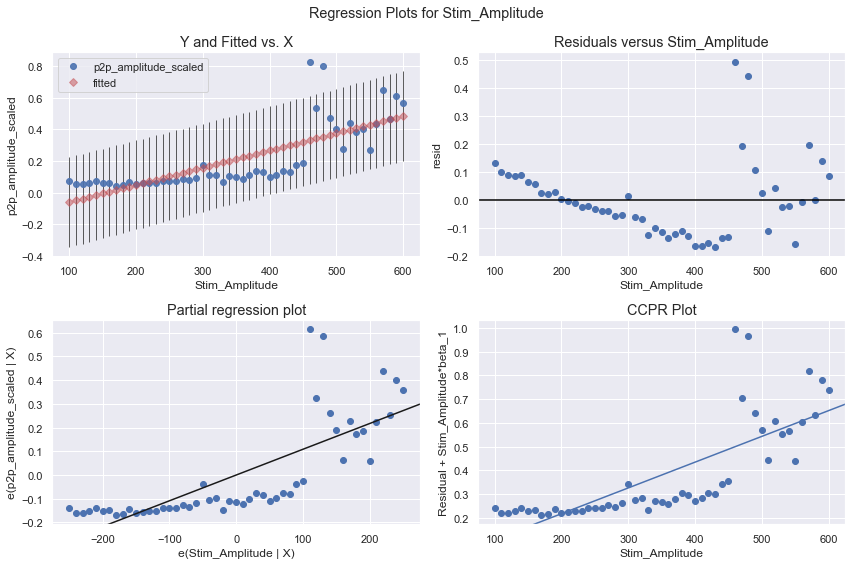

In [78]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

sns.set(font_scale=1)

model = ols('p2p_amplitude_scaled ~ Stim_Amplitude', data=df_p2p_scaled[(df_p2p_scaled['Animal']=='N27') & (df_p2p_scaled['Day_Stim']==3)]).fit()
print(model.summary())

fig = plt.figure(figsize=(12,8))
fig = sm.graphics.plot_regress_exog(model, 'Stim_Amplitude', fig=fig)

In [79]:
# # fig = plt.figure(figsize=(12,8))
# # sns.set(font_scale=1)
# # r2 = np.asarray([])

# for animal in df_p2p_scaled.Animal.unique():
#     for day in df_p2p_scaled[df_p2p_scaled['Animal']==animal].Day_Stim.unique():
#         model = ols('p2p_amplitude_scaled ~ Stim_Amplitude', data=df_p2p_scaled[(df_p2p_scaled['Animal']==animal) & (df_p2p_scaled['Day_Stim']==day)]).fit()
# #         model = ols('p2p_amplitude_scaled ~ Stim_Amplitude', data=df_p2p_scaled[(df_p2p_scaled['Animal']==animal)]).fit()

# #         print(model.summary())

# #         fig = plt.figure(figsize=(12,8))
# #         fig = sm.graphics.plot_regress_exog(model, 'Stim_Amplitude', fig=fig)
# #         r2 = np.append(r2, model.rsquared)
#         print('Animal: ' + animal + '. Day: ' + str(day) + '. R^2: ' + str(model.rsquared))

        
        
        
# # #view model summary
# # print(model.summary())
# #         model.rsquared
# #         np.sum(model.resid)
# # #fit simple linear regression model
# # model = ols('p2p_amplitude_scaled ~ Stim_Amplitude', data=df_p2p_scaled[(df_p2p_scaled['Animal']=='N01') & (df_p2p_scaled['Day_Stim']==1)]).fit()


#### Export dataframe to csv for statistical modelling in R

In [80]:
df_p2p_scaled.to_csv('D:\\df_p2p_scaled.csv')

In [81]:
df_p2p_scaled.Animal.unique()

array(['N01', 'N04', 'N05', 'N09', 'N10', 'N11', 'N13', 'N14', 'N15',
       'N16', 'N17', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25',
       'N26', 'N27', 'N28', 'N30', 'N31', 'N32', 'N33', 'N34'],
      dtype=object)

In [82]:
df_p2p_scaled.groupby('Animal')['Day_Stim'].unique()

Animal
N01    [1, 2, 3, 4]
N04       [1, 2, 4]
N05       [1, 2, 4]
N09    [1, 2, 3, 4]
N10    [1, 2, 3, 4]
N11    [1, 2, 3, 4]
N13    [1, 2, 3, 4]
N14    [1, 2, 3, 4]
N15    [1, 2, 3, 4]
N16    [1, 2, 3, 4]
N17    [1, 2, 3, 4]
N19    [1, 2, 3, 4]
N20    [1, 2, 3, 4]
N21    [1, 2, 3, 4]
N22    [1, 2, 3, 4]
N23    [1, 2, 3, 4]
N24    [1, 2, 3, 4]
N25    [1, 2, 3, 4]
N26    [1, 2, 3, 4]
N27    [1, 2, 3, 4]
N28    [1, 2, 3, 4]
N30    [1, 2, 3, 4]
N31    [1, 2, 3, 4]
N32    [1, 2, 3, 4]
N33    [1, 2, 3, 4]
N34    [1, 2, 3, 4]
Name: Day_Stim, dtype: object

In [83]:
# df_p2p_scaled.tails(10)

In [84]:
df_p2p_scaled.groupby(['Animal'])['Hours_Stim'].unique()

Animal
N01      [0.0, 5.0, 7.0, 23.0]
N04            [0.0, 7.0, 1.5]
N05           [0.0, 7.0, 20.0]
N09    [0.0, 14.0, 21.0, 22.0]
N10    [0.0, 20.0, 22.0, 14.0]
N11          [0.0, 21.0, 22.0]
N13          [0.0, 24.0, 28.0]
N14                      [0.0]
N15                      [0.0]
N16                      [0.0]
N17                      [0.0]
N19                      [0.0]
N20                      [0.0]
N21                      [0.0]
N22                      [0.0]
N23                      [0.0]
N24                      [0.0]
N25                      [0.0]
N26                      [0.0]
N27                [0.0, 12.0]
N28                [0.0, 12.0]
N30                [0.0, 12.0]
N31                [0.0, 12.0]
N32                [0.0, 12.0]
N33                [0.0, 12.0]
N34                [0.0, 22.0]
Name: Hours_Stim, dtype: object

<Figure size 1440x1440 with 0 Axes>

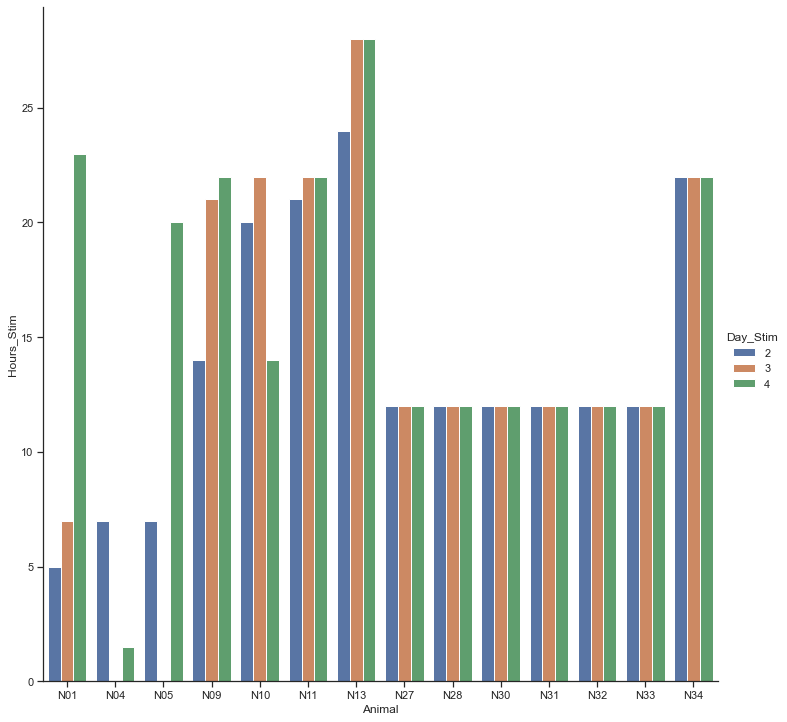

In [85]:
plt.figure(figsize=(20,20))
sns.set(font_scale=1)
sns.set_style("ticks")

sns.catplot(
    data=df_p2p_scaled[df_p2p_scaled['Hours_Stim']>0], kind="bar",
    x="Animal", y="Hours_Stim", hue="Day_Stim",
    ci="sd", height=10
)

In [86]:
df_hours_plot = df_p2p_scaled.copy()

def custom_round(x, base):
    return int(base * round(float(x)/base))

df_hours_plot['Stim_Amplitude'] = df_hours_plot['Stim_Amplitude'].apply(lambda x: custom_round(x, base=50))

df_hours_plot['Stim_Amplitude'].unique()

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700, 750, 800, 850, 900], dtype=int64)

In [87]:
# plt.figure(figsize=(20,20))
# sns.set(font_scale=1)
# sns.set_style("darkgrid")
# rp = sns.lmplot(x="Hours_Stim", y="p2p_amplitude_scaled", col="Day_Stim", hue='Stim_Amplitude', data=df_hours_plot[(df_hours_plot['Group']=='Yes Injury, Yes Therapy')],
#            col_wrap=2, palette="mako", height=4, ci=0,
#            scatter_kws={"s": 50, "alpha": 0.3})

# rp.fig.subplots_adjust(top=0.9)
# rp.fig.suptitle('Group = Yes Injury, Yes Therapy')
# rp.set(xlabel='Stimulation Duration (hours)', ylabel='Evoked Potential Amplitude')


In [88]:
# plt.figure(figsize=(20,20))
# sns.set(font_scale=1)
# sns.set_style("darkgrid")
# rp = sns.lmplot(x="Hours_Stim", y="p2p_amplitude_scaled", col="Day_Stim", hue='Stim_Amplitude', data=df_hours_plot[(df_hours_plot['Group']=='No Injury, Yes Therapy')],
#            col_wrap=2, palette="mako", height=4, ci=0,
#            scatter_kws={"s": 50, "alpha": 0.3})

# rp.fig.subplots_adjust(top=0.9)
# rp.fig.suptitle('Group = No Injury, Yes Therapy')
# rp.set(xlabel='Stimulation Duration (hours)', ylabel='Evoked Potential Amplitude')


In [89]:
df_p2p_scaled.head()

Animal  Day_Stim  Stim_Amplitude  p2p_amplitude_scaled               Group  \
0    N01         1            10.0              0.044218  No Injury, Yes EES   
2    N01         1            20.0              0.045537  No Injury, Yes EES   
4    N01         1            30.0              0.047929  No Injury, Yes EES   
6    N01         1            40.0              0.061401  No Injury, Yes EES   
8    N01         1            50.0              0.086936  No Injury, Yes EES   

   Hours_Stim  
0         0.0  
2         0.0  
4         0.0  
6         0.0  
8         0.0

C:\Users\Ian\anaconda3\lib\site-packages\seaborn\matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\Ian\anaconda3\lib\site-packages\seaborn\matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


[Text(0.5, 1.0, 'No Injury, Yes Therapy')]

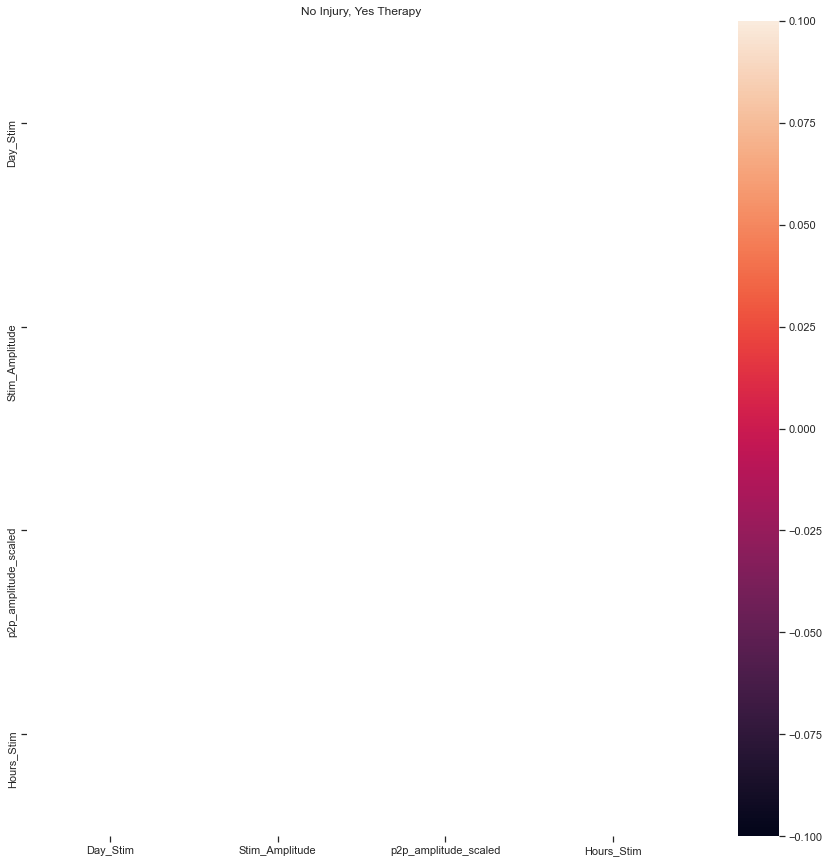

In [90]:
sns.heatmap(df_hours_plot[df_hours_plot['Group']=='No Injury, Yes Therapy'].corr(),annot=True,lw=1).set(title='No Injury, Yes Therapy')

[Text(0.5, 1.0, 'Yes Injury, Yes Therapy')]

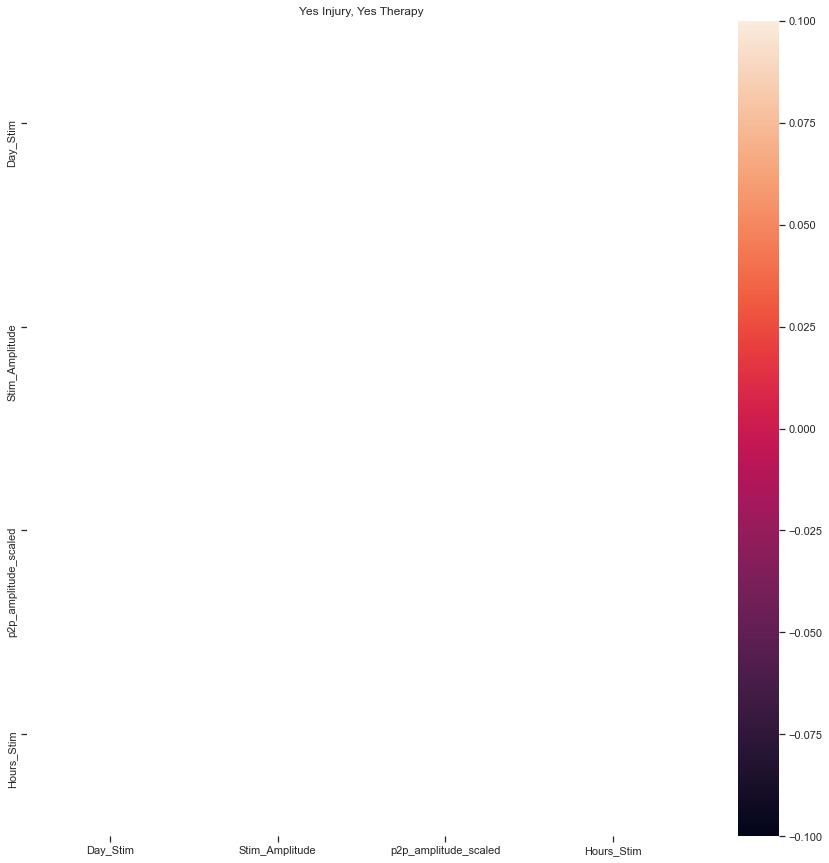

In [91]:
sns.heatmap(df_hours_plot[df_hours_plot['Group']=='Yes Injury, Yes Therapy'].corr(),annot=True,lw=1).set(title='Yes Injury, Yes Therapy')

<Figure size 2160x2160 with 0 Axes>

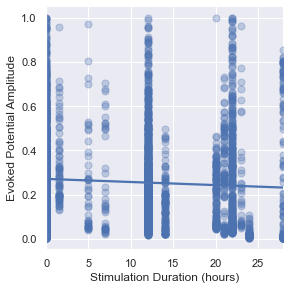

In [92]:
sns.set(font_scale=1)
sns.set_style("darkgrid")
plt.figure(figsize=(30,30))

ax = sns.lmplot(x="Hours_Stim", y="p2p_amplitude_scaled", data=df_hours_plot,
           palette="mako", height=4, ci=0,
           scatter_kws={"s": 50, "alpha": 0.3})
ax.set(xlabel='Stimulation Duration (hours)', ylabel='Evoked Potential Amplitude')

# rp.fig.subplots_adjust(top=0.9)
# rp.fig.suptitle('Group = No Injury, Yes Therapy')
# rp.set(xlabel='Stimulation Duration (hours)', ylabel='Evoked Potential Amplitude')
ax.savefig("D:\\all_vars.png")




In [93]:
X = df_hours_plot[['Hours_Stim']] 
y = df_hours_plot['p2p_amplitude_scaled']
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     p2p_amplitude_scaled   R-squared:                       0.004
Model:                              OLS   Adj. R-squared:                  0.003
Method:                   Least Squares   F-statistic:                     14.34
Date:                  Mon, 06 Sep 2021   Prob (F-statistic):           0.000155
Time:                          21:53:49   Log-Likelihood:                 420.70
No. Observations:                  3876   AIC:                            -837.4
Df Residuals:                      3874   BIC:                            -824.9
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2714      0.005     56.598      0.000       0.262       0.281
Hours_Stim    -0.0014      0.000     -3.786      0.000      -0.002      -0.001
==============================================================================
Omnibus:                      622.165   Durbin-Watson:                   0.339
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              960.991
Skew:                           1.147   Prob(JB):                    2.11e-209
Kurtosis:                       3.832   Cond. No.                         17.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
X = df_hours_plot[['Day_Stim', 'Stim_Amplitude', 'Group', 'Hours_Stim']] 
y = df_hours_plot['p2p_amplitude_scaled']
X = pd.get_dummies(data=X, drop_first=True)
X.head()

Day_Stim  Stim_Amplitude  Hours_Stim  Group_No Injury, Yes EES  \
0         1               0         0.0                         1   
2         1               0         0.0                         1   
4         1              50         0.0                         1   
6         1              50         0.0                         1   
8         1              50         0.0                         1   

   Group_Yes Injury, No EES  Group_Yes Injury, Yes EES  
0                         0                          0  
2                         0                          0  
4                         0                          0  
6                         0                          0  
8                         0                          0

In [95]:
# X = df_hours_plot[['Day_Stim', 'Stim_Amplitude', 'Group', 'Hours_Stim']] 
# y = df_hours_plot['p2p_amplitude_scaled']
## fit a OLS model with intercept on TV and Radio
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     p2p_amplitude_scaled   R-squared:                       0.432
Model:                              OLS   Adj. R-squared:                  0.432
Method:                   Least Squares   F-statistic:                     491.2
Date:                  Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                          21:53:49   Log-Likelihood:                 1511.1
No. Observations:                  3876   AIC:                            -3008.
Df Residuals:                      3869   BIC:                            -2964.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0828      0.011     -7.670      0.000      -0.104      -0.062
Day_Stim                      0.0182      0.003      6.318      0.000       0.013       0.024
Stim_Amplitude                0.0007   1.47e-05     50.817      0.000       0.001       0.001
Hours_Stim                   -0.0005      0.000     -1.216      0.224      -0.001       0.000
Group_No Injury, Yes EES      0.0589      0.009      6.905      0.000       0.042       0.076
Group_Yes Injury, No EES      0.2095      0.014     15.037      0.000       0.182       0.237
Group_Yes Injury, Yes EES     0.0443      0.009      4.785      0.000       0.026       0.062
==============================================================================
Omnibus:                      500.337   Durbin-Watson:                   0.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.385
Skew:                           0.925   Prob(JB):                    4.65e-166
Kurtosis:                       4.137   Cond. No.                     2.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Time of Day of MEP

In [96]:
# import time of day dataframe

df_mep_time = pd.read_csv('D:\\time_of_day_mep.csv')
df_mep_time = pd.wide_to_long(df_mep_time, stubnames='day', i=['Animal'], j='Day_Stim', sep='_').reset_index()
df_mep_time = df_mep_time.rename(columns={'day':'Time_of_MEP'})
df_mep_time = df_mep_time.dropna()
df_mep_time.head()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\time_of_day_mep.csv'

In [ ]:
# normalize time of day
df_mep_time['radian_time'] = 2 * np.pi * df_mep_time['Time_of_MEP'] / 24

# make sine and cosine time features
df_mep_time['cos_time'] = np.cos(df_mep_time['radian_time'])
df_mep_time['sin_time'] = np.sin(df_mep_time['radian_time'])

df_mep_time.head()

In [ ]:
df_time = df_p2p_scaled.copy()
df_time = df_time.drop(columns=['Hours_Stim'])
df_time = pd.merge(left=df_time, right=df_mep_time, how='left', left_on=['Animal', 'Day_Stim'], right_on=['Animal', 'Day_Stim'])

df_time.head()

In [ ]:
df_time.Group.unique()

In [ ]:
def add_inj_col(row):
    if "Yes Injury" in row['Group']:
        val = 1
    else:
        val = 0
    return val

def add_stim_col(row):
    if "Yes EES" in row['Group']:
        val = 1
    else:
        val = 0
    return val

In [ ]:
df_time['Injury'] = df_time.apply(add_inj_col, axis=1)
df_time['Stimulation'] = df_time.apply(add_stim_col, axis=1)
df_time.head()

In [ ]:
sns.set(font_scale=2)
sns.set_style("ticks")
sns.despine()
sns.lmplot(x="cos_time", y="p2p_amplitude_scaled", ci=95, data=df_time, height=8.27, aspect=11.7/8.27)

In [ ]:
X = df_time[['Day_Stim', 'Stim_Amplitude', 'Injury', 'Stimulation', 'Time_of_MEP']] 
y = df_time['p2p_amplitude_scaled']
X.head()

In [ ]:
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

In [ ]:
X = df_time[['Day_Stim', 'Stim_Amplitude', 'Injury', 'Stimulation', 'cos_time']] 
y = df_time['p2p_amplitude_scaled']
X.head()

In [ ]:
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

#### Time between stim and MEP

In [ ]:
# import time of day dataframe

df_tb = pd.read_csv('D:\\time_between_no_early.csv')
df_tb = pd.wide_to_long(df_tb, stubnames='day', i=['Animal'], j='Day_Stim', sep='_').reset_index()
df_tb = df_tb.rename(columns={'day':'Time_Between_Stim_MEP'})
df_tb = df_tb.dropna()
df_tb.head()

In [ ]:
df_between = df_p2p_scaled.copy()
df_between = df_between[df_between['Day_Stim'] > 1]
df_between['Injury'] = df_between.apply(add_inj_col, axis=1)
df_between['Stimulation'] = df_between.apply(add_stim_col, axis=1)
df_between = df_between[df_between['Stimulation'] == 1]
df_between = pd.merge(left=df_between, right=df_tb, how='left', left_on=['Animal', 'Day_Stim'], right_on=['Animal', 'Day_Stim'])
df_between = df_between.dropna()
df_between.head()

In [97]:
X = df_between[['Day_Stim', 'Stim_Amplitude', 'Injury',  'Time_Between_Stim_MEP']] 
y = df_between['p2p_amplitude_scaled']
X.head()

NameError: name 'df_between' is not defined

In [ ]:
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

#### Stimulation Amplitude

In [98]:
# import time of day dataframe

df_stim_amp = pd.read_csv('D:\\stim_amp.csv')
df_stim_amp = pd.wide_to_long(df_stim_amp, stubnames='day', i=['Animal'], j='Day_Stim', sep='_').reset_index()
df_stim_amp = df_stim_amp.rename(columns={'day':'ees_amplitude'})
df_stim_amp = df_stim_amp.dropna()
df_stim_amp.head()

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\stim_amp.csv'

In [ ]:
df_ees_amp = df_p2p_scaled.copy()
df_ees_amp = df_ees_amp[df_ees_amp['Day_Stim'] > 1]
df_ees_amp['Injury'] = df_ees_amp.apply(add_inj_col, axis=1)
df_ees_amp['Stimulation'] = df_ees_amp.apply(add_stim_col, axis=1)
df_ees_amp = df_ees_amp[df_ees_amp['Stimulation'] == 1]
df_ees_amp = pd.merge(left=df_ees_amp, right=df_stim_amp, how='left', left_on=['Animal', 'Day_Stim'], right_on=['Animal', 'Day_Stim'])
df_ees_amp = df_ees_amp.dropna()
df_ees_amp.head()

In [ ]:
X = df_ees_amp[['Day_Stim', 'Stim_Amplitude', 'Injury', 'ees_amplitude']] 
y = df_ees_amp['p2p_amplitude_scaled']
X.head()

In [99]:
X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     p2p_amplitude_scaled   R-squared:                       0.432
Model:                              OLS   Adj. R-squared:                  0.432
Method:                   Least Squares   F-statistic:                     491.2
Date:                  Mon, 06 Sep 2021   Prob (F-statistic):               0.00
Time:                          21:53:50   Log-Likelihood:                 1511.1
No. Observations:                  3876   AIC:                            -3008.
Df Residuals:                      3869   BIC:                            -2964.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.0828      0.011     -7.670      0.000      -0.104      -0.062
Day_Stim                      0.0182      0.003      6.318      0.000       0.013       0.024
Stim_Amplitude                0.0007   1.47e-05     50.817      0.000       0.001       0.001
Hours_Stim                   -0.0005      0.000     -1.216      0.224      -0.001       0.000
Group_No Injury, Yes EES      0.0589      0.009      6.905      0.000       0.042       0.076
Group_Yes Injury, No EES      0.2095      0.014     15.037      0.000       0.182       0.237
Group_Yes Injury, Yes EES     0.0443      0.009      4.785      0.000       0.026       0.062
==============================================================================
Omnibus:                      500.337   Durbin-Watson:                   0.377
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              761.385
Skew:                           0.925   Prob(JB):                    4.65e-166
Kurtosis:                       4.137   Cond. No.                     2.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
# import statsmodels.api as sm

# df_ols = df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='Yes Injury, Yes Stimulation') & (df_p2p_ratio_max['Day_Stim']==2)]

# X=df_ols['Hours_Stim']
# Y=df_ols['p2p_ratio_max']
# X = sm.add_constant(X) # add intercept

# model = sm.OLS(Y, X).fit()
# predictions = model.predict(X) 

# print_model = model.summary()
# print(print_model)

In [101]:
# sns.lmplot(x="Stim_Amplitude", y="p2p_ratio_max", col="Day_Stim", data=df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='Yes Injury, Yes Stimulation')],
#            col_wrap=2, ci=95, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 0.3})

In [102]:
# df_ols = df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='Yes Injury, Yes Stimulation') & (df_p2p_ratio_max['Day_Stim']==4)]

# X=df_ols['Stim_Amplitude']
# Y=df_ols['p2p_ratio_max']
# X = sm.add_constant(X) # add intercept

# model = sm.OLS(Y, X).fit()
# predictions = model.predict(X) 

# print_model = model.summary()
# print(print_model)


In [103]:
# sns.lmplot(x="Hours_Stim", y="p2p_ratio_max", col="Day_Stim", data=df_p2p_ratio_max[df_p2p_ratio_max['Group']=='No Injury, Yes Stimulation'],
#            col_wrap=2, ci=95, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 0.3})

In [104]:
# sns.set(font_scale=1)
# stim_amps = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550]

# sns.lmplot(x="Hours_Stim", y="p2p_ratio_max", col="Stim_Amplitude", data=df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='No Injury, Yes Stimulation') & (df_p2p_ratio_max['Stim_Amplitude'].isin(stim_amps))],
#            col_wrap=2, ci=95, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 0.3})

In [105]:
# df_ols = df_p2p_ratio_max[(df_p2p_ratio_max['Group']=='No Injury, Yes Stimulation') & (df_p2p_ratio_max['Day_Stim']==4)]

# X=df_ols['Hours_Stim']
# Y=df_ols['p2p_ratio_max']
# X = sm.add_constant(X) # add intercept

# model = sm.OLS(Y, X).fit()
# predictions = model.predict(X) 

# print_model = model.summary()
# print(print_model)

In [106]:
# df_p2p_ratio_max.head()

In [107]:
# stim_amp_list = [200, 250, 300, 350, 400, 450, 500, 600]

# sns.set(font_scale=1)
# sns.set_style("ticks")
# sns.despine()
# plt.figure(figsize=(20,12))

# plt.figure(figsize=(20,20))
# sns.set_style("ticks")
# g = sns.FacetGrid(df_p2p_ratio_max[df_p2p_ratio_max['Stim_Amplitude'].isin(stim_amp_list)], col="Group")
# g = (g.map(sns.scatterplot, "Stim_Amplitude", "p2p_ratio_max", 'Day_Stim').add_legend())

In [108]:
# sns.lmplot(x="Stim_Amplitude", y="p2p_ratio_max", col="Group", hue="Day_Stim", data=df_p2p_ratio_max,
#            col_wrap=2, ci=95, palette="muted", height=4,
#            scatter_kws={"s": 50, "alpha": 0.1})

#### Look at p2p for each animal and each side

In [109]:
# g = sns.FacetGrid(df_p2p_ratio_max, col='Side', row='Animal', hue='Day_Stim')
# g.map_dataframe(sns.scatterplot, x='Stim_Amplitude', y='p2p_ratio_max')
# g.add_legend()

## Feature exploration and importance for peak-to-peak amplitude


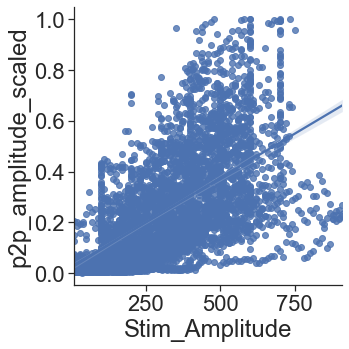

In [88]:
sns.lmplot(data=df_p2p_scaled, x="Stim_Amplitude", y="p2p_amplitude_scaled")

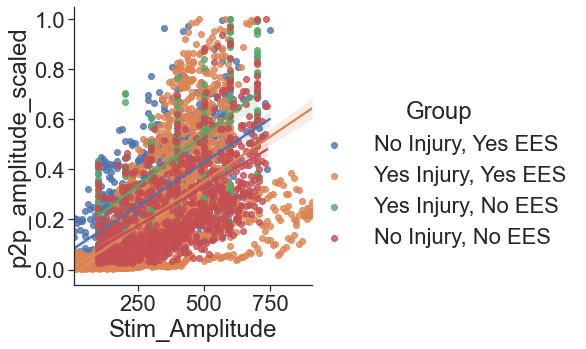

In [89]:
sns.lmplot(data=df_p2p_scaled, x="Stim_Amplitude", y="p2p_amplitude_scaled", hue="Group")

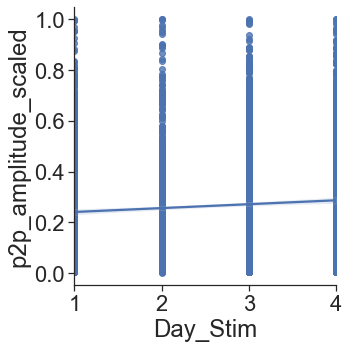

In [90]:
sns.lmplot(data=df_p2p_scaled, x="Day_Stim", y="p2p_amplitude_scaled")

<AxesSubplot:xlabel='Day_Stim', ylabel='p2p_amplitude_scaled'>

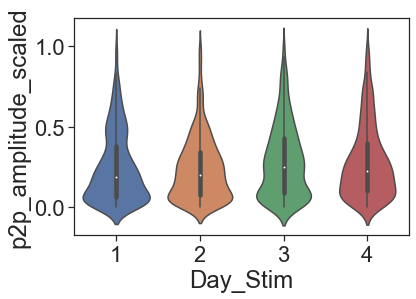

In [91]:
sns.violinplot(data=df_p2p_scaled, x="Day_Stim", y="p2p_amplitude_scaled")

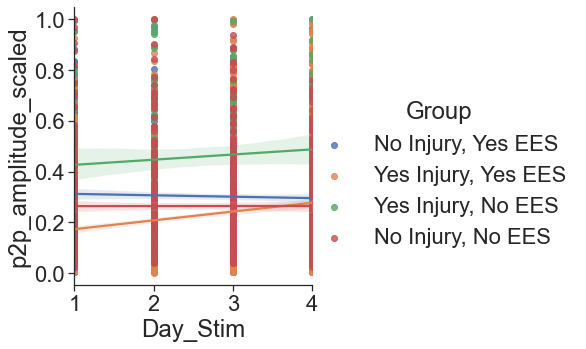

In [92]:
sns.lmplot(data=df_p2p_scaled, x="Day_Stim", y="p2p_amplitude_scaled", hue="Group")

<AxesSubplot:xlabel='Day_Stim', ylabel='p2p_amplitude_scaled'>

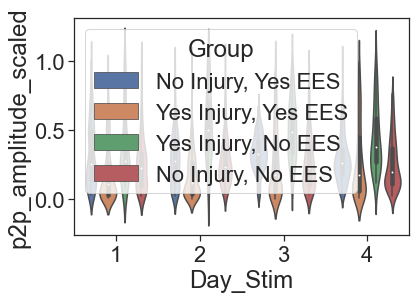

In [93]:
sns.violinplot(data=df_p2p_scaled, x="Day_Stim", y="p2p_amplitude_scaled", hue="Group")

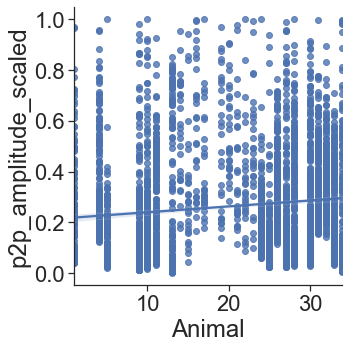

In [94]:
# is there a systematic difference across data of data collection?
# ie. are earlier animals difference than later animals

df_animalnumber = df_p2p_scaled.copy()
df_animalnumber['Animal'] = df_animalnumber['Animal'].str[1:].astype('int64')
sns.lmplot(data=df_animalnumber, x="Animal", y="p2p_amplitude_scaled")

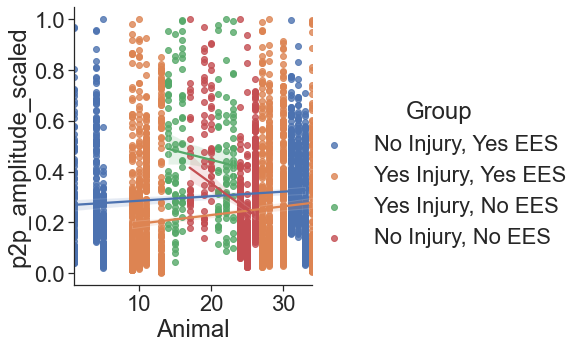

In [95]:
sns.lmplot(data=df_animalnumber, x="Animal", y="p2p_amplitude_scaled", hue="Group")

In [96]:
# df_p2p_ratio_max.head()

In [97]:
# df_kbest = df_animalnumber.copy()
# df_kbest = df_kbest.drop(columns=['Side'])

# # from sklearn.feature_selection import SelectKBest
# # from sklearn.feature_selection import chi2
# # X = df_kbest.iloc[:,[0,1,2,4]]  #independent columns
# # y = df_kbest.iloc[:,3]    #target column i.e price range
# # #apply SelectKBest class to extract top 10 best features
# # bestfeatures = SelectKBest(score_func=chi2, k=10)
# # fit = bestfeatures.fit(X,y)
# # dfscores = pd.DataFrame(fit.scores_)
# # dfcolumns = pd.DataFrame(X.columns)
# # #concat two dataframes for better visualization 
# # featureScores = pd.concat([dfcolumns,dfscores],axis=1)
# # featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# # print(featureScores.nlargest(10,'Score'))  #print 10 best features


# X = df_animalnumber.iloc[:,[0,1,2,3,5]]  #independent columns
# y = df_animalnumber.iloc[:,4]    #target column i.e price range
# from sklearn.ensemble import ExtraTreesClassifier
# import matplotlib.pyplot as plt
# model = ExtraTreesClassifier()
# model.fit(X,y)
# print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
# #plot graph of feature importances for better visualization
# feat_importances = pd.Series(model.feature_importances_, index=X.columns)
# feat_importances.nlargest(10).plot(kind='barh')
# plt.show()

## Peak-to-peak latency analysis (3.75 ms time bins)

In [98]:
# df_bin = df_sta_noart[df_sta_noart['Time'] <= 15].copy()
# df_bin['Bin'] = pd.cut(df_bin.Time, 
#                 bins=[0,3.75,7.5,11.25], 
#                 include_lowest=True, 
#                 labels=['0-3.75ms','3.75-7.5ms','7.5-11.25ms'])
# df_bin = df_bin.dropna()
# df_bin.head()

In [99]:
# df_p2p_latency = df_bin.copy()
# df_p2p_latency = df_p2p_latency.groupby(['Animal', 'Day_Stim', 'Stim_Amplitude', 'Bin'])['STA_Amplitude'].apply(lambda x: x.max() + abs(x.min())).reset_index().rename(columns={'STA_Amplitude':'p2p_amplitude'})
# df_p2p_latency.head()

In [100]:
# df_p2p_latency = df_p2p_latency.merge(df_p2p_latency.groupby(['Animal'])['p2p_amplitude'].max(), on='Animal', how='left')
# df_p2p_latency['p2p_ratio_max'] = df_p2p_latency['p2p_amplitude_x'] / df_p2p_latency['p2p_amplitude_y']
# df_p2p_latency = df_p2p_latency.drop(columns=['p2p_amplitude_x', 'p2p_amplitude_y'])
# df_p2p_latency.head()

In [101]:
# add_group(df_p2p_latency)
# df_p2p_latency.head()

In [102]:
# df_p2p_latency_mean = df_p2p_latency.groupby(['Group', 'Day_Stim', 'Stim_Amplitude', 'Bin'])['p2p_ratio_max'].agg('mean').reset_index().rename(columns={'p2p_ratio_max':'mean_p2p_ratio_max'}).copy()
# df_p2p_latency_mean.head()

In [103]:
# df_p2p_latency_mean['Day_Stim'].unique()

#### Plotting

In [104]:
# stimamps = [200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400]
# days = [1, 4]

# df_plot = df_p2p_latency_mean[df_p2p_latency_mean['Stim_Amplitude'].isin(stimamps) & df_p2p_latency['Day_Stim'].isin(days)].copy()
# df_plot = df_plot.rename(columns={"Bin": "Time Bin", "mean_p2p_ratio_max": "Mean Peak-to-Peak Amplitude (mV)", 'Day_Stim':'Day'})

In [105]:
# sns.set(font_scale=2)
# sns.set_style("ticks")
# g = sns.FacetGrid(df_plot, col="Group", size=6, palette='tab10')
# g = (g.map(sns.scatterplot, "Time Bin", "Mean Peak-to-Peak Amplitude (mV)", 'Day', s=75).add_legend())
# plt.savefig('D:\\test.png')

## Spike P2P

In [106]:
filename = 'ian_2021_02_18_MEP_reformatted'

project = 'NEIL' if 'NEIL' in filename else 'SPARC'
path = 'D:\\Dataframe_CSVs\\%s.csv' % filename

df_spike_p2p = pd.read_csv(path)

In [107]:
df_spike_p2p.head()

animal  stim_amp  left_0_p2p  left_1_p2p  left_2_p2p  left_3_p2p  \
0    N34       100    0.058285    0.073897    0.021596    0.130937   
1    N34       110    0.025594    0.150029    0.026110    0.080430   
2    N34       120    0.038084    0.045427    0.037755    0.140675   
3    N34       130    0.034803    0.149995    0.048413    0.382579   
4    N34       140    0.089865    0.153758    0.395963    0.435916   

   left_4_p2p  right_0_p2p  right_1_p2p  right_2_p2p  right_3_p2p  right_4_p2p  
0    0.085119     0.072823     0.216535     0.204672     0.256578     0.258001  
1    0.028070     0.092374     0.249334     0.232758     0.223908     0.182822  
2    0.114606     0.124031     0.240828     0.194209     0.344865     0.186777  
3    0.338746     0.147740     0.417845     0.198024     0.211190     0.091727  
4    0.319633     0.102643     0.193853     0.601254     0.330093     0.237811

In [108]:
df_spike_long = pd.melt(df_spike_p2p, id_vars=['animal', 'stim_amp'], value_vars=['left_0_p2p', 'left_1_p2p', 'left_2_p2p', 'left_3_p2p','left_4_p2p','right_0_p2p','right_1_p2p','right_2_p2p','right_3_p2p','right_4_p2p'])
df_spike_long[['side','day', 'metric']] = df_spike_long['variable'].str.split('_',expand=True)
df_spike_long = df_spike_long.drop(columns=['variable', 'metric'])
df_spike_long = df_spike_long.dropna()
df_spike_long = df_spike_long.astype({'day': 'int'})
df_spike_long.head()

animal  stim_amp     value  side  day
0    N34       100  0.058285  left    0
1    N34       110  0.025594  left    0
2    N34       120  0.038084  left    0
3    N34       130  0.034803  left    0
4    N34       140  0.089865  left    0

<Figure size 432x288 with 0 Axes>

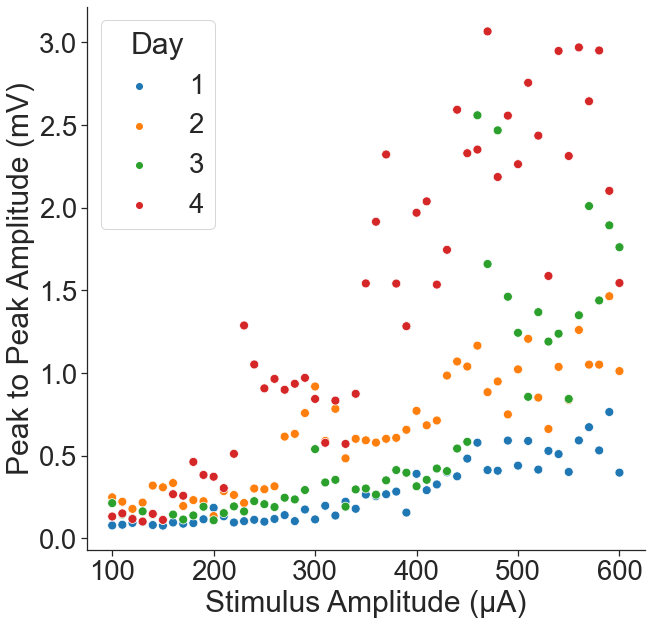

In [109]:
# Representative plot for presentations

sns.set(font_scale=2.5)
sns.set_style("ticks")
sns.despine()
plt.figure(figsize=(10,10))


ax = sns.scatterplot(data=df_p2p[(df_p2p['Animal']=='N27')], 
                x='Stim_Amplitude', y='p2p_amplitude', palette='tab10', hue='Day_Stim', s=80)
ax.set(xlabel='Stimulus Amplitude (μA)', ylabel='Peak to Peak Amplitude (mV)')
ax.legend().set_title('Day')
sns.despine()
ax.figure.savefig("D:\\N09_representative.png")

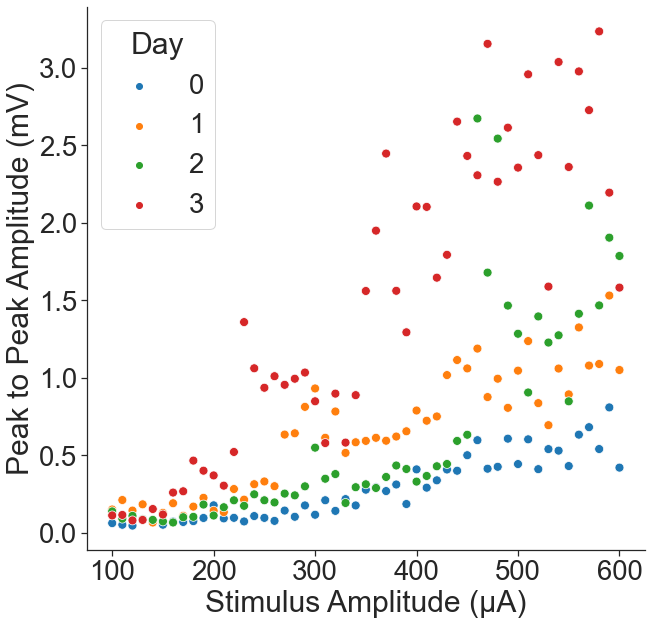

In [110]:
# Representative plot for presentations



plt.figure(figsize=(10,10))

ax = sns.scatterplot(data=df_spike_long[(df_spike_long['animal']=='N27') & (df_spike_long['day'] < 4) & (df_spike_long['side']=='left')], 
                x='stim_amp', y='value', palette='tab10', hue='day', s=80)
ax.set(xlabel='Stimulus Amplitude (μA)', ylabel='Peak to Peak Amplitude (mV)')
ax.legend().set_title('Day')
sns.despine()
#ax.figure.savefig("D:\\N09_representative.png")

In [111]:
df_spike_long.dtypes

animal       object
stim_amp      int64
value       float64
side         object
day           int32
dtype: object

In [112]:
df_spike_long.head()

animal  stim_amp     value  side  day
0    N34       100  0.058285  left    0
1    N34       110  0.025594  left    0
2    N34       120  0.038084  left    0
3    N34       130  0.034803  left    0
4    N34       140  0.089865  left    0

In [114]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(20,20))
# sns.set_style("ticks")
# g = sns.FacetGrid(df_auc, col="Group")
# g = (g.map(sns.scatterplot, "Stim_Amplitude", "STA_AUC", 'Day_Stim').add_legend())

### Calculate statistics on the plotted lines above
##### slope, intercept, r_value, p_value, std_err

Make dataframes for each group. This will make it easier to subset in the next step.

In [115]:
# # group: no injury, no stimulation
# df_nn = df_ratio_max[df_ratio_max['Group'] == 'No Injury, No Stimulation']
# df_nn1 = df_nn[df_nn['Day_Stim'] == 1]
# df_nn2 = df_nn[df_nn['Day_Stim'] == 2]
# df_nn3 = df_nn[df_nn['Day_Stim'] == 3]
# df_nn4 = df_nn[df_nn['Day_Stim'] == 4]

# # group: no injury, yes stimulation
# df_ny = df_ratio_max[df_ratio_max['Group'] == 'No Injury, Yes Stimulation']
# df_ny1 = df_ny[df_ny['Day_Stim'] == 1]
# df_ny2 = df_ny[df_ny['Day_Stim'] == 2]
# df_ny3 = df_ny[df_ny['Day_Stim'] == 3]
# df_ny4 = df_ny[df_ny['Day_Stim'] == 4]

# # group: yes injury, no stimulation
# df_yn = df_ratio_max[df_ratio_max['Group'] == 'Yes Injury, No Stimulation']
# df_yn1 = df_yn[df_yn['Day_Stim'] == 1]
# df_yn2 = df_yn[df_yn['Day_Stim'] == 2]
# df_yn3 = df_yn[df_yn['Day_Stim'] == 3]
# df_yn4 = df_yn[df_yn['Day_Stim'] == 4]

# # group: yes injury, yes stimulation
# df_yy = df_ratio_max[df_ratio_max['Group'] == 'Yes Injury, Yes Stimulation']
# df_yy1 = df_yy[df_yy['Day_Stim'] == 1]
# df_yy2 = df_yy[df_yy['Day_Stim'] == 2]
# df_yy3 = df_yy[df_yy['Day_Stim'] == 3]
# df_yy4 = df_yy[df_yy['Day_Stim'] == 4]

In [116]:
# from scipy import stats
# from sklearn.linear_model import LinearRegression
# import statsmodels.api as sm

# df = df_yy4

# X = df['Stim_Amplitude']
# y = df['p2p_ratio_max']

# X2 = sm.add_constant(X)
# est = sm.OLS(y, X2)
# est2 = est.fit()
# print(est2.summary())

### Apply linear mixed effects model (random slopes) to data plotted above

In [117]:
# df_ratio_max.head()

In [118]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# md = sm.MixedLM.from_formula("p2p_ratio_max ~ Stim_Amplitude + Day_Stim", df_ratio_max, groups=df_ratio_max["Group"])

# mdf = md.fit()

# print(mdf.summary())

### Calculate area under the stimulus triggered average curves 
##### For each current amplitude, each animal, and each day

In [119]:
#### KEEP THIS. MAY SPLIT INTO TIME BINS IN FUTURE

# bins = [0.001, 0.004, 0.007, 0.010, 0.013, 0.0298] # define bins
# labels = ['1 to 4 ms', '4 to 7 ms', '7 to 10 ms', '10 to 13 ms', '13 to 29.8 ms'] # define bin labels
# #labels = [1, 2, 3, 4, 5]

# df_bin = df_sta_sub_norm.copy()
# df_bin['Time_Bin'] = pd.cut(df_bin['Time'], bins, labels=labels, right=False) # add Time_Bin column to dataframe
# df_bin = df_bin.reindex(columns=['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Time', 'Time_Bin', 'STA_Scaled'])
# df_bin.rename(columns = {'Time_Bin':'Bin'}, inplace = True) 
# df_bin = df_bin[df_bin['Bin'] != '13 to 29.8 ms'] # drop all data 13 ms after the stimulation
# df_bin.head()


# from scipy import integrate

# df_auc = df_bin.groupby(['Animal', 'Day', 'Side', 'Stim_Amplitude', 'Bin'])['STA_Scaled'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Scaled':'STA_AUC'}, inplace = True)
# df_auc = df_auc.dropna()
# df_auc.head()

In [120]:
# df_noisefloor_auc = df_sta_noart.copy()
# df_noisefloor_auc = df_noisefloor_auc[(df_noisefloor_auc['Time'] > 20.0)]
# df_noisefloor_auc.head()

In [121]:
# df_auc = df_sta_noart.copy()
# df_auc = df_auc[(df_auc['Time'] > 2.0) & (df_auc['Time'] < 10.2)]
# df_auc.tail()

In [122]:
# import numpy as np
# # define animal groups
# injstim = ['N09','N10','N11','N13','N27','N28','N29','N30']
# noinjstim = ['N01','N04','N05','N31','N32','N33','N34','N35'] 
# injnostim = ['N14','N15','N16','N21','N22','N23','N36','N37']
# noinjnostim = ['N17','N19','N20','N24','N25','N26','N38','N39'] 

# # add animal group information to the dataframe
# conditions = [
#     (df_auc['Animal'].isin(injstim) ),
#     (df_auc['Animal'].isin(noinjstim) ),
#     (df_auc['Animal'].isin(injnostim) ),
#     (df_auc['Animal'].isin(noinjnostim) )]
# choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']
# df_auc['Group'] = np.select(conditions, choices)
# df_auc.head()

In [123]:
# df_noisefloor_peak = df_noisefloor_auc.copy()
# df_noisefloor_peak = df_noisefloor_peak.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
# df_noisefloor_peak = df_noisefloor_peak.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
# df_noisefloor_peak.head()

In [124]:
# df_noisefloor_auc = df_noisefloor_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude'])['STA_Amplitude'].agg('mean').reset_index()
# df_noisefloor_auc['STA_Amplitude'] = df_noisefloor_auc['STA_Amplitude'] * 7.8 # 7.8 because the length of the STA is 7.8 ms
# df_noisefloor_auc = df_noisefloor_auc.rename(columns={"STA_Amplitude": "STA_Noise_Floor"})
# df_noisefloor_auc.head()

In [125]:
# df_peak = df_auc.copy()
# df_peak = df_peak.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].agg('max').reset_index()
# df_peak.rename(columns = {'STA_Amplitude':'STA_Peak'}, inplace = True)
# df_peak = df_peak.drop(columns=['Day_Postop', 'Side'])
# df_peak.head()

We now need to integrate the stimulus triggered average curves to find the area beneath them. We can then compare these areas under the curve (AUCs) between groups, days, stimulus intensities, etc.

The trapezoidal rule provides a simple way to integrate a function but typically has much larger error than Simpson's rule without saving significant compute time. We will use Simpson's rule.

In [126]:
# from scipy import integrate

# df_auc = df_auc.groupby(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
# df_auc = df_auc.drop(columns=['Day_Postop', 'Side'])
# df_auc.head()

In [127]:
# df_peak.to_csv('D:\\df_peak_raw.csv', index=False) 
# df_auc.to_csv('D:\\df_auc_raw.csv', index=False) 

In [128]:
# # one hot encoding for injury condition and stimulation condition

# choices = ['Injury and Stimulation', 'No Injury and Stimulation', 'Injury and No Stimulation', 'No Injury and No Stimulation']

# def injury(row):
#     if (row['Group'] == 'Injury and Stimulation') | (row['Group'] == 'Injury and No Stimulation'):
#         val = 1
#     elif (row['Group'] == 'No Injury and Stimulation') | (row['Group'] == 'No Injury and No Stimulation'):
#         val = 0
#     else:
#         val = -1
#     return val

# def stimulation(row):
#     if (row['Group'] == 'Injury and Stimulation') | (row['Group'] == 'No Injury and Stimulation'):
#         val = 1
#     elif (row['Group'] == 'Injury and No Stimulation') | (row['Group'] == 'No Injury and No Stimulation'):
#         val = 0
#     else:
#         val = -1
#     return val

In [129]:
# # percent change from noise floor to peak for each day

# df_peak_change = df_peak.copy()
# df_peak_change["STA_Noise_Floor"] = df_noisefloor_peak["STA_Noise_Floor"]
# df_peak_change['STA_Percent_Noise_Floor'] = ((df_peak_change['STA_Peak'].sub(df_peak_change["STA_Noise_Floor"])).div(df_peak_change["STA_Noise_Floor"])).mul(100)
# df_peak_change.head()

In [130]:
# df_peak_change['Injury'] = df_peak_change.apply(injury, axis=1)
# df_peak_change['Stimulation'] = df_peak_change.apply(stimulation, axis=1)
# df_peak_change = df_peak_change.drop(columns=['STA_Peak', 'STA_Noise_Floor'])
# df_peak_change.rename(columns = {'STA_Percent_Noise_Floor':'Peak_Percent_Noise_Floor'}, inplace = True) 
# df_peak_change.head()


In [131]:
# df_mean_day_peak_change = df_peak_change.copy()
# df_mean_day_peak_change = df_mean_day_peak_change.groupby(['Day_Stim', 'Stim_Amplitude', 'Group'])['Peak_Percent_Noise_Floor'].agg('mean').reset_index()
# df_mean_day_peak_change = df_mean_day_peak_change.rename(columns={'Peak_Percent_Noise_Floor':'Mean_Peak_Percent_Noise_Floor'})
# df_mean_day_peak_change.head()

In [132]:
# stim_amp_list = [200, 250, 300, 350, 400, 450, 500, 600]
# import seaborn as sns
# import matplotlib.pyplot as plt
# plt.figure(figsize=(20,20))
# # sns.set(font_scale=2)
# sns.set_style("ticks")
# g = sns.FacetGrid(df_mean_day_peak_change[(df_mean_day_peak_change['Stim_Amplitude'].isin(stim_amp_list)) & (df_mean_day_peak_change['Day_Stim']>0)], col="Group")
# g = (g.map(sns.scatterplot, "Stim_Amplitude", "Mean_Peak_Percent_Noise_Floor", 'Day_Stim').add_legend())


In [133]:
# # percent change from noise floor to auc for each day

# df_day_auc_change = df_auc.copy()
# df_day_auc_change["STA_Noise_Floor"] = df_noisefloor_auc["STA_Noise_Floor"]
# df_day_auc_change['STA_Percent_Noise_Floor'] = ((df_day_auc_change['STA_AUC'].sub(df_day_auc_change["STA_Noise_Floor"])).div(df_day_auc_change["STA_Noise_Floor"])).mul(100)
# df_day_auc_change.head()

In [134]:
# df_day_auc_change['Injury'] = df_day_auc_change.apply(injury, axis=1)
# df_day_auc_change['Stimulation'] = df_day_auc_change.apply(stimulation, axis=1)
# #df_day_pchange = df_day_pchange.drop(columns=['Day_Postop', 'Side', 'STA_AUC', 'STA_Noise_Floor'])
# #df_day_pchange.to_csv('D:\\df_abstract.csv', index=False) 
# # df_day_pchange.head(50)
# df_day_auc_change = df_day_auc_change.drop(columns=['STA_AUC', 'STA_Noise_Floor'])
# df_day_auc_change.rename(columns = {'STA_Percent_Noise_Floor':'AUC_Percent_Noise_Floor'}, inplace = True) 

# df_day_auc_change.head()

In [135]:
# df_cluster = df_day_auc_change.copy()
# df_cluster = df_cluster.drop(columns=['Injury','Stimulation'])
# df_cluster = df_cluster.set_index('Animal')
# df_cluster = df_cluster[df_cluster['Stim_Amplitude'] < 800]
# # df_cluster['AnimalID'] = [int(x.strip()[-2:]) for x in df_cluster['Animal']]
# # df_cluster = df_cluster.drop(columns=['Animal'])
# # df_cluster = df_cluster[(df_cluster['Day_Stim'] == 3) | (df_cluster['Day_Stim'] == 4)]
# # df_cluster = df_cluster[(df_cluster['Stim_Amplitude'] > 299) & (df_cluster['Stim_Amplitude'] < 510)]
# # df_cluster = df_cluster.groupby(['AnimalID', 'Injury', 'Stimulation', ])['AUC_Percent_Noise_Floor'].agg('mean').reset_index()
# df_cluster.head(30)

In [136]:
# from mpl_toolkits.mplot3d import Axes3D

# sns.set(style = "darkgrid")

# fig = plt.figure()
# ax = fig.add_subplot(111, projection = '3d')

# x = df_cluster['Day_Stim']
# y = df_cluster['Stim_Amplitude']
# z = df_cluster['AUC_Percent_Noise_Floor']

# ax.set_xlabel("Day_Stim")
# ax.set_ylabel("Stim_Amplitude")
# ax.set_zlabel("AUC_Percent_Noise_Floor")

# ax.scatter(x, y, z)

# plt.show()

In [137]:
# df_cluster.head(50)

In [138]:
# model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
#                                      linkage='complete').fit(df_cluster)
# Z = hierarchy.linkage(model.children_, 'complete')
# plt.figure(figsize=(20,10))
# dn = hierarchy.dendrogram(Z)

In [139]:
# from sklearn.cluster import AgglomerativeClustering

# clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None, affinity='euclidean', 
#                                      linkage='complete').fit(df_day_auc_change)


In [140]:
# from scipy.cluster.hierarchy import dendrogram
# from scipy.cluster import hierarchy

# Z = hierarchy.linkage(clustering.children_, 'complete')


# plt.figure(figsize=(20,10))
# dn = hierarchy.dendrogram(Z)

In [141]:
# df_day_auc_change.head()

In [142]:
# df_cluster = df_day_auc_change[df_day_auc_change['Stim_Amplitude']]

In [143]:
# df_timeseries = df_auc.copy()
# df_timeseries['Injury'] = df_timeseries.apply(injury, axis=1)
# df_timeseries['Stimulation'] = df_timeseries.apply(stimulation, axis=1)
# df_timeseries.head()

In [144]:


# from scipy.cluster.hierarchy import dendrogram

# def plot_dendrogram(model, **kwargs):
#     # Create linkage matrix and then plot the dendrogram

#     # create the counts of samples under each node
#     counts = np.zeros(model.children_.shape[0])
#     n_samples = len(model.labels_)
#     for i, merge in enumerate(model.children_):
#         current_count = 0
#         for child_idx in merge:
#             if child_idx < n_samples:
#                 current_count += 1  # leaf node
#             else:
#                 current_count += counts[child_idx - n_samples]
#         counts[i] = current_count

#     linkage_matrix = np.column_stack([model.children_, model.distances_,
#                                       counts]).astype(float)

#     # Plot the corresponding dendrogram
#     dendrogram(linkage_matrix, **kwargs)
    
# plt.title('Hierarchical Clustering Dendrogram')
# # plot the top three levels of the dendrogram
# plot_dendrogram(clustering, truncate_mode='level', p=3)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [145]:
# df_auc = df_sta_noart[df_sta_noart['Time'] <= 15].copy()
# add_group(df_auc)
# df_auc.head()

In [146]:
# df_auc['STA_Amplitude'] = df_auc['STA_Amplitude'].abs()

In [147]:
# df_auc.head()

In [148]:
# from scipy import integrate

# df_auc = df_auc.group
# by(['Animal', 'Day_Postop', 'Day_Stim', 'Side', 'Stim_Amplitude', 'Group'])['STA_Amplitude'].apply(integrate.simps).reset_index()
# df_auc.rename(columns = {'STA_Amplitude':'STA_AUC'}, inplace = True)
# df_auc.head()

In [149]:
# df_auc.to_csv('D:\\CSV_Outputs\\df_auc.csv', index=False) 


In [150]:
# # these are dataframes that erica requested for abstract

# df_peak_400 = df_peak_change.copy()
# df_peak_day4 = df_peak_change.copy()
# df_auc_400 = df_day_pchange.copy()
# df_auc_day4 = df_day_pchange.copy()

# df_peak_400 = df_peak_400[df_peak_400['Stim_Amplitude'] == 400]
# df_peak_day4 = df_peak_day4[df_peak_day4['Day_Stim'] == 4]
# df_auc_400 = df_auc_400[df_auc_400['Stim_Amplitude'] == 400]
# df_auc_day4 = df_auc_day4[df_auc_day4['Day_Stim'] == 4]

# df_peak_400.to_csv('D:\\df_peak_400.csv', index=False) 
# df_peak_day4.to_csv('D:\\df_peak_day4.csv', index=False) 
# df_auc_400.to_csv('D:\\df_auc_400.csv', index=False) 
# df_auc_day4.to_csv('D:\\df_auc_day4.csv', index=False) 

# df_peak_400_day4 = df_peak_400.copy()
# df_peak_400_day4 = df_peak_400_day4[df_peak_400_day4['Day_Stim'] == 4]

# df_auc_400_day4 = df_auc_400.copy()
# df_auc_400_day4 = df_auc_400_day4[df_auc_400_day4['Day_Stim'] == 4]

# df_peak_400_day4.to_csv('D:\\df_peak_400_day4.csv', index=False) 
# df_auc_400_day4.to_csv('D:\\df_auc_400_day4.csv', index=False) 

# df_auc = df_day_pchange.copy()
# df_peak = df_peak_change.copy()
# df_auc.to_csv('D:\\df_auc.csv', index=False) 
# df_peak.to_csv('D:\\df_peak.csv', index=False) 

# CODE BELOW THIS NEEDS TO BE INTEGRATED TO CODE ABOVE

In [151]:
# # function to calculate percent change
# def perc_change_from_d4(df, day):
#     return ((df[str(day)].sub(df['4'])).div(df['4'])).mul(100)

In [152]:
# ### changed function above to take df arg

# df_auc_pchange = df_auc.pivot_table(index=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], 
#                     columns='Day', 
#                     values='STA_AUC').reset_index()

# for n in np.arange(6,20,2):
#     df_auc_pchange["Day 4 to Day %s" % n] = perc_change_from_d4(n)

# df_auc_pchange = df_auc_pchange.drop(df_auc_pchange.columns[5:13], axis=1)
# df_auc_pchange.head()

In [153]:
# df_auc_pchange = pd.melt(df_auc_pchange, id_vars=['Animal', 'Side', 'Stim_Amplitude', 'Bin', 'Group'], var_name='Days', value_name='Percent_Change')
# df_auc_pchange.head()

In [154]:
# df_auc_pchange[(df_auc_pchange['Group'] == 'Group C') & (df_auc_pchange['Days'] == 'Day 4 to Day 16') & (df_auc_pchange['Animal'] == 'S05')].head(50)

In [155]:
# # all the bar plots
# sns.set(font_scale=1.5)
# g = sns.FacetGrid(df_auc_pchange, col="Days", row='Bin')
# g.map(sns.barplot, "Group", "Percent_Change", 'Stim_Amplitude')

In [156]:
# day_range = 'Day 4 to Day 18'

# plt.figure(figsize=(20,12))
# sns.set(font_scale=2)
# sns.set_style("ticks")
# ax = sns.boxplot(x='Group', y='Percent_Change', hue='Stim_Amplitude', data=df_auc_pchange[df_auc_pchange['Days'] == day_range])
# ax.legend(loc="upper left", title='Stimulation Amplitude (uA)', title_fontsize="small")
# ax.set_title(project + ': Percent Change AUC ' + day_range)
# ax.set_ylabel('Percent Change STA AUC')